# 0.0 Setup

## Import packages

In [ ]:
!pip install geovoronoi
!pip install geopandas==0.8.0
!pip install geoplot 
!pip install geojsoncontour
!pip install alphashape
!pip uninstall pygeos 
!pip install contextily

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#progress bar
from tqdm.notebook import tqdm

# comment out packages not required for loading
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
import itertools

# magic command to render plots properly in notebook
%matplotlib inline


In [ ]:
import geopandas as gpd
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
from shapely.geometry import Polygon
import geoplot
from scipy.spatial import ConvexHull
from shapely.ops import cascaded_union
from folium import plugins
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
import matplotlib
import branca.colormap as cmp
import folium # map rendering library
from folium import plugins
from folium.plugins import MeasureControl
from geojson import Point, Feature, FeatureCollection, dump
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import shape, GeometryCollection
from shapely.ops import cascaded_union
import shapely.wkt
#import pygeos
#import rtree

## Mount Google Drive & Set Filepaths

In [ ]:
# if using Google Colab to read data from Google My drive, use the following 2 commands
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [84]:
# Set filepath for parent 0_Data dir,Eaglebine and Duvernay subdirectories
dir_main = '/content/drive/MyDrive/Colab Notebooks/0_Data/'
dir_eaglebine = '/content/drive/MyDrive/Colab Notebooks/0_Data/Eaglebine/Eaglebine/'
dir_duvernay = '/content/drive/MyDrive/Colab Notebooks/0_Data/Duvernay/Duvernay/'
dir_notebook = '/content/drive/MyDrive/Colab Notebooks/0_Data/Output/'



---


#1.0 Introduction: Define Problem

## 1.1 Geothermal Energy: History and Future

Renewable energy has received increasing attention due to people's awareness of climate change. According to EIA, 90% of new power capacity in 2020 were generated in renewables (https://www.iea.org/reports/renewables-2020). Geothermal energy, thermal energy that is generated from subsurface of the earth,  generated 15.5GW power which constituted 7.7% of renewable energy in 2020 globally.

Since ancient times, hot springs generated by geothermal energy has been used for bathing. Using geothermal energy for direct heating can be traced back to 15th century. In 1904, the first geothermal power generator was built in Lardarello, Italy. With emerging new technologies and attention to clean energy, capacity and efficiency of utilizing geothermal energy has been growing in the past decade. Global cumulative geothermal capacity is forecast to increase 7% to 16.5GW by 2022. Compared to other forms of renewable energy (solar, wind or biomass) geothermal energy is more stable, constant and less environment dependent.



## 1.2 Geothermal Energy and Well Repurposing

Typically a well needs to be drilled to extract geothermal energy from subsurface. Depth of drilling depends on purpose of usage (direct use or power generation) and thermal gradient of the formation. If the formation is relatively cool we have to drill deep to gain access to hot enough formation.
Drilling new geothermal wells is very expensive and can be up to 50% of the total project cost. (https://geothermalcommunities.eu/assets/elearning/9.17.COSTS.pdf)

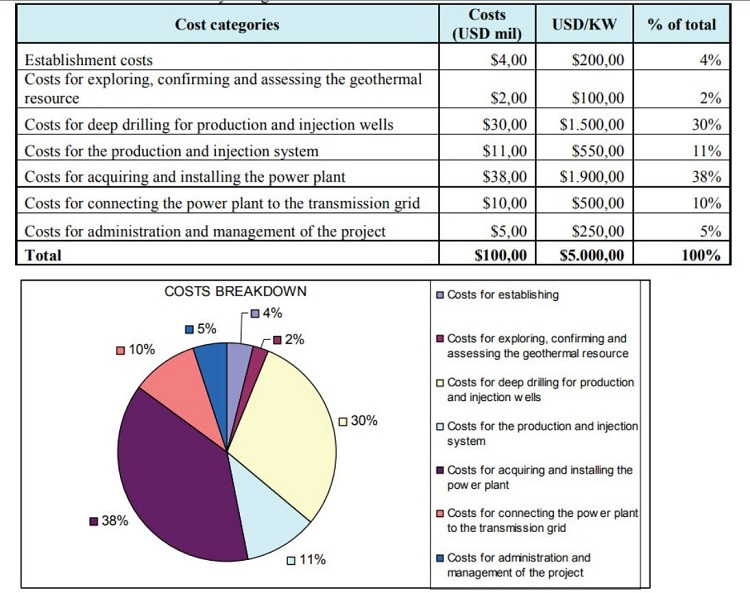

On the other hand, the cost of permanent shutdown, plug, remove wellhead, and reclamation can be a heavy financial burden for companies especially under sustained period of low commodity prices. Companies often hold wells in abandonment status to avoid and delay such cost. There is also risk for these wells to become orphan wells if its owner cannot be held accountable. As of **April 2021**, Alberta has approximately 97,000 inactive wells, 71,000 abandoned wells and 2,124 orphan wells according to the Alberta Government (https://www.alberta.ca/oil-and-gas-liabilities-management.aspx) and Orphan Well Association (http://www.orphanwell.ca/about/orphan-inventory/).
Repurposing abandoned oil industry wells in sedimentary formations for geothermal purpose could be perfect a marriage for two. Because not only does it provide a valuable new source of geothermal energy but also provides a good opportunity to convert these environmental burden to generate clean and sustainable energy.

The Canadian Federal government will spend \$1.7 billion to help clean up orphaned and abandoned oil and gas wells in Alberta, Saskatchewan and B.C. The United Conservative government in Alberta has already extended a \$100-million loan to the Orphan Wells Association to accelerate reclamation work. For US, the Biden administration’s infrastructure plans to set aside $16 Billion to plug some old oil wells and clean up some mines. These funds could potentially be used for re-purposing wells.

As of October 31, 2016, there are ​over 60,000 oil and gas wells in Alberta that have the potential for geothermal production. The wells are divided into three categories, based on the temperature at the bottom of the well:

-Power Generation (>120°C) : about 500 wells

-Industrial Heat (>90°C): about 7,200 wells

-Direct Heat (>60°C): about 53,000 wells

(https://www.cangea.ca/reportanddashboards.html)

## 1.3 Problem: How to Evaluate the Potential of Converting Oil & Gas Wells for Geothermal Purpose

While repurposing old wells can be a win-win situation for interested parties, blind selection of orphan wells for conversion may result in significant capital losses.

Essentially an ideal candidate for repurposing will have the right reservoir or aquifer and well bore conditions, proximity to electricity or heat markets, and with good economics.

In this datathon, we were provided well information in the forms of well logs, production and drilling data were collected for two basins (one in US and the other in Canada) and challenged to predict the true formation temperature from measured bottom hole temperature (BHT) quantitatively and evaluate the potential of wells qualitatively. 


# 2.0 Data Wrangling

## 2.1 Overview

The Eaglebine dataset consists of 8 dataframes obtained from csv/xlsx files, and 1 large dataframe dictionary obtained from LAS files with petrophysical information per well.
- BHT bottom hole temperatures (1 row per well)
- Synthetic temperatures (several rows per well, temperatures along wellbore)
- Static temperatures (1 row per well, where available)
- Well header information (1 row per well)
- Mudweight information (1 row per well)
- Formation tops (1 row per well)
- Production summary (1 row per well)
- Casing information (1 row per well)

The diagram below shows a schematic of data entities available and their relationships. Only selected key features are shown for each entity for illustrative purposes. The "red" entities are related to well temperatures, the "blue" one is related to LAS petrophysical data and the "yellow" one contain other general well information. 
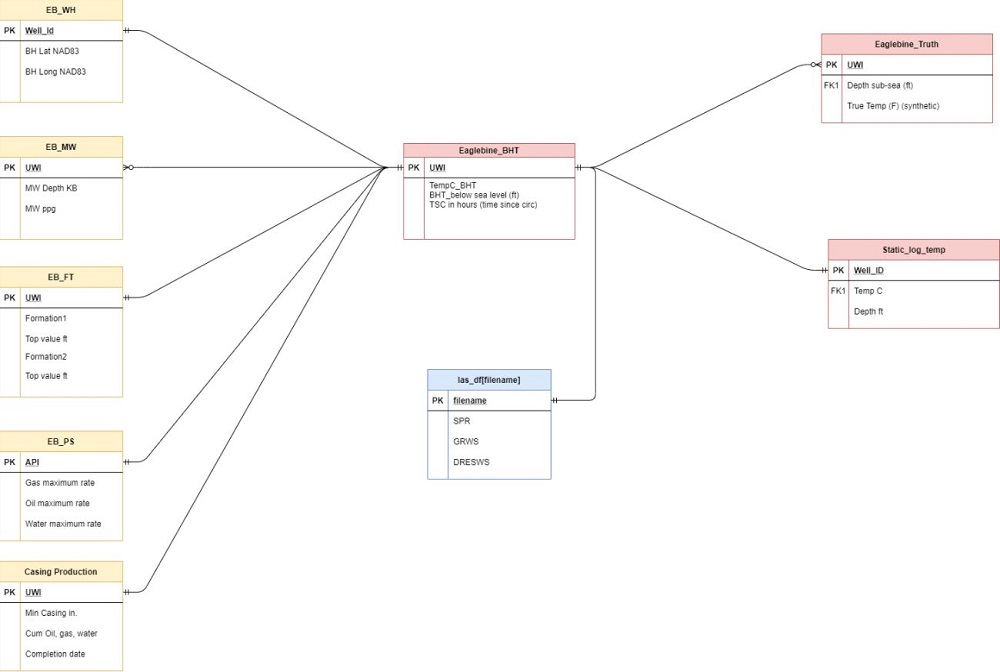



Naming of DataFrame

DataFrame Name| Description |
-------------------|------------------|
Field_BHT      | Measured BHT data|
Field_Truth| synthetic formation temperatures|
Static_log_temp| Measured static temperature |
Field_Combined_stat| Merged dataframe contains UWI, location, depth, measured BHT, <br> and true temperature used for model training. When measured  <br>static temperature exists it is assigned to true temperature  <br>otherwise sythetic formation temperature is used|
Field_Combined_full_synth| Field_Combined_stat with sythetic formation temperature  <br>added to each depth of well|
GTX_features_Field| Dataset Combined Field_Combined_full_synth with mud weight, <br> formation tops, well hearders, production summary|
GTX_features | Final dataset for modelling. Combined cleaned datasets for both fileds|

## 2.2 Process Eaglebine Data

### 2.2.1 Read Eaglebine Temperature Data

Read in BHT

In [ ]:
Eaglebine_BHT = pd.read_excel(dir_eaglebine+'Eaglebine BHT TSC data for SPE April 21 2020.xlsx')
Eaglebine_BHT['TempC_BHT'] = (Eaglebine_BHT['BHTorMRT (maximum recorded temperature) oF'] - 32) * (5./9.)
Eaglebine_BHT.head()

UWI  ...   TempC_BHT
0  42013301410000  ...   61.666667
1  42013301930000  ...  107.222222
2  42013302760000  ...   65.555556
3  42013305480000  ...   76.666667
4  42013310190000  ...   98.888889

[5 rows x 10 columns]

In [ ]:
print("number of unique wells: " + str(len(pd.unique(Eaglebine_BHT['UWI']))))

number of unique wells: 324


Read in Eaglebine synthetic "true formation temperatures"

In [ ]:
Eaglebine_Truth = pd.read_excel(dir_eaglebine+'Eaglebine TrueTemp_Train2.xlsx')
Eaglebine_Truth.head()

UWI  Depth sub-sea (feet)  True Temperature   (oF)
0  42013301410000                  -350                    70.33
1  42013301410000                  -300                    70.33
2  42013301410000                  -250                    70.33
3  42013301410000                  -200                    71.49
4  42013301410000                  -150                    72.66

In [ ]:
# convert to Celsius
Eaglebine_Truth['TempTrue_degC'] = (Eaglebine_Truth['True Temperature   (oF)'] - 32) * (5./9.)

In [ ]:
print("number of unique wells in Eaglebine in training set: " + str(len(pd.unique(Eaglebine_Truth['UWI']))))

number of unique wells in Eaglebine in training set: 243


Read in static temperature information

In [ ]:
Static_log_temp = pd.read_csv(dir_main+'Data_static_logs.csv')
Static_log_temp.head()

Well_ID  Depth (ft)  Temp (degC)      Field
0  42013301930000     10700.0   132.778000  Eaglebine
1  42041305800000      7360.0    82.777778  Eaglebine
2  42041311700000      7828.0   118.888889  Eaglebine
3  42041311980000      7954.0   105.000000  Eaglebine
4  42051305380000      8380.0   111.111111  Eaglebine

### 2.2.2 Combine BHT with "True" temperature (synthetic or static)

In [ ]:
# Merge BHT and Synthetic
Eaglebine_Truth['TrueTemp_datasource_syn'] = 'synthetic'
Eaglebine_Combined = Eaglebine_BHT.merge(Eaglebine_Truth, on='UWI', how='left')

In [ ]:
Eaglebine_Combined.head()

UWI    SurfLat  ...  TempTrue_degC  TrueTemp_datasource_syn
0  42013301410000  28.690426  ...      21.294444                synthetic
1  42013301410000  28.690426  ...      21.294444                synthetic
2  42013301410000  28.690426  ...      21.294444                synthetic
3  42013301410000  28.690426  ...      21.938889                synthetic
4  42013301410000  28.690426  ...      22.588889                synthetic

[5 rows x 14 columns]

In [ ]:
# from the synthetic data, only keep the temperature at the elevation closest to the BHT depth
Eaglebine_Combined['diff_depth'] = Eaglebine_Combined['Depth sub-sea (feet)']-Eaglebine_Combined['BHT_below sea level (ft)']
Eaglebine_Combined['diff_depth_abs'] = np.abs(Eaglebine_Combined['diff_depth'])
idx = Eaglebine_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Eaglebine_Combined['diff_depth_abs']
TrueTempUWI = Eaglebine_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'TempTrue_degC', 'Depth sub-sea (feet)', 'TrueTemp_datasource_syn']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Eaglebine_Combined_cln = Eaglebine_BHT.merge(TrueTempUWI, on='UWI', how='left')
Eaglebine_Combined_cln.head()

UWI    SurfLat  ...  Depth sub-sea (feet)  TrueTemp_datasource_syn
0  42013301410000  28.690426  ...               12200.0                synthetic
1  42013301930000  28.779921  ...               10400.0                synthetic
2  42013302760000  28.994360  ...                5750.0                synthetic
3  42013305480000  28.759118  ...                7800.0                synthetic
4  42013310190000  28.817400  ...               10500.0                synthetic

[5 rows x 14 columns]

In [ ]:
# Merge now static data
Eaglebine_Combined_cln['UWI'] = Eaglebine_Combined_cln['UWI'].astype(str)
Eaglebine_Combined_cln = Eaglebine_Combined_cln.copy(deep=True)
# Eaglebine_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Eaglebine_Combined_stat = Eaglebine_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [ ]:
# Coalesce columns together with priority for "true" temperature measurement
# Try to use static first
# if not available then use synthetic
Eaglebine_Combined_stat['TempC_Fin'] = Eaglebine_Combined_stat['Temp (degC)'].fillna(Eaglebine_Combined_stat['TempTrue_degC'])
Eaglebine_Combined_stat['TrueTemp_datasource'] = Eaglebine_Combined_stat['TrueTemp_datasource_stat'].fillna(Eaglebine_Combined_stat['TrueTemp_datasource_syn'])
Eaglebine_Combined_stat.head()

UWI    SurfLat  ...   TempC_Fin  TrueTemp_datasource
0  42013301410000  28.690426  ...  141.555556            synthetic
1  42013301930000  28.779921  ...  132.778000     static_temp_logs
2  42013302760000  28.994360  ...   89.161111            synthetic
3  42013305480000  28.759118  ...  107.961111            synthetic
4  42013310190000  28.817400  ...  133.722222            synthetic

[5 rows x 21 columns]

In [ ]:
Eaglebine_Combined_stat.groupby(['UWI']).ngroups

324

### 2.2.3 Add All Synthetic Data Available at Different Depth

In [ ]:
# Extra table: create Full Synthetic table with BHT information (more data points per well)
Eaglebine_BHT_str = Eaglebine_BHT.copy()
# use BHT list as master. Pull GL attribute
Eaglebine_BHT_str = Eaglebine_BHT_str[['UWI', 'GL(ft)']].merge(Eaglebine_Truth[['UWI','Depth sub-sea (feet)','TempTrue_degC']], on='UWI', how='left')
Eaglebine_BHT_str['UWI'] = Eaglebine_BHT_str['UWI'].astype(str)
# add BHT values at appropiate depths
selected_cols = ['UWI','BHT_below sea level (ft)','BHT_ subsurface (ft)','TSC or ORT (time since circulation or original recorded time in hours)', 'TempC_BHT', 'Depth sub-sea (feet)',
                 'TempC_Fin', 'TrueTemp_datasource']
Eaglebine_Combined_full_synth = Eaglebine_BHT_str.merge(Eaglebine_Combined_stat[selected_cols], on=['UWI', 'Depth sub-sea (feet)'], how='left')


In [ ]:
Eaglebine_Combined_full_synth.rename(columns={'Depth sub-sea (feet)':'Synth_mdSS_ft', 'TempTrue_degC':'Synth_Value_C',
                                              'BHT_below sea level (ft)':'BHT_Depth_mdSS_ft','BHT_ subsurface (ft)': 'BHT_Depth_mdGL_ft', 
                                              'TSC or ORT (time since circulation or original recorded time in hours)':'Time_SC_hrs', 'TempC_BHT': 'BHT_Value_C',
                                              'TempC_Fin':'True_Temp_C','TrueTemp_datasource':'True_Temp_Source'}, inplace=True)

In [ ]:
Eaglebine_Combined_full_synth.head()

UWI  GL(ft)  ...  True_Temp_C  True_Temp_Source
0  42013301410000   345.9  ...          NaN               NaN
1  42013301410000   345.9  ...          NaN               NaN
2  42013301410000   345.9  ...          NaN               NaN
3  42013301410000   345.9  ...          NaN               NaN
4  42013301410000   345.9  ...          NaN               NaN

[5 rows x 10 columns]

In [ ]:
Eaglebine_Combined_full_synth.shape

(66470, 10)

In [ ]:
Eaglebine_Combined_full_synth.loc[Eaglebine_Combined_full_synth['True_Temp_Source'].isnull()]

UWI  GL(ft)  ...  True_Temp_C  True_Temp_Source
0      42013301410000   345.9  ...          NaN               NaN
1      42013301410000   345.9  ...          NaN               NaN
2      42013301410000   345.9  ...          NaN               NaN
3      42013301410000   345.9  ...          NaN               NaN
4      42013301410000   345.9  ...          NaN               NaN
...               ...     ...  ...          ...               ...
66465  42507326870000   787.9  ...          NaN               NaN
66466  42507326870000   787.9  ...          NaN               NaN
66467  42507326870000   787.9  ...          NaN               NaN
66468  42507326870000   787.9  ...          NaN               NaN
66469  42507326870000   787.9  ...          NaN               NaN

[66227 rows x 10 columns]

In [ ]:
# fill-in true temp. True temp values at any depth other than at BHT/Static, will come from the synthetic
Eaglebine_Combined_full_synth['True_Temp_C'] = Eaglebine_Combined_full_synth['True_Temp_C'].fillna(Eaglebine_Combined_full_synth['Synth_Value_C'])

# Labeling of datasource for synthetic temperature points.
fill_in_condition = (Eaglebine_Combined_full_synth['True_Temp_Source'].isnull()) & ~(Eaglebine_Combined_full_synth['Synth_Value_C'].isnull())
Eaglebine_Combined_full_synth['True_Temp_Source'] = Eaglebine_Combined_full_synth['True_Temp_Source'].mask(fill_in_condition,'synthetic')
Eaglebine_Combined_full_synth.head()


UWI  GL(ft)  ...  True_Temp_C  True_Temp_Source
0  42013301410000   345.9  ...    21.294444         synthetic
1  42013301410000   345.9  ...    21.294444         synthetic
2  42013301410000   345.9  ...    21.294444         synthetic
3  42013301410000   345.9  ...    21.938889         synthetic
4  42013301410000   345.9  ...    22.588889         synthetic

[5 rows x 10 columns]

In [ ]:
Eaglebine_Combined_full_synth.loc[Eaglebine_Combined_full_synth['True_Temp_Source'].isnull()]

UWI  GL(ft)  ...  True_Temp_C  True_Temp_Source
3339   42013339770000   483.4  ...          NaN               NaN
4289   42013340740000   499.4  ...          NaN               NaN
4290   42013342130000   478.4  ...          NaN               NaN
4291   42021301990000   340.4  ...          NaN               NaN
5012   42041303170000   362.1  ...          NaN               NaN
...               ...     ...  ...          ...               ...
63472  42493306840000   388.0  ...          NaN               NaN
64391  42493311060000   579.4  ...          NaN               NaN
64392  42493311680000   477.1  ...          NaN               NaN
65846  42493322270000   487.4  ...          NaN               NaN
66101  42507312420000   660.7  ...          NaN               NaN

[81 rows x 10 columns]

In [ ]:
Eaglebine_Combined_full_synth.groupby(['UWI']).ngroups

324

### 2.2.4 Read in Eaglebine mud weight, formation tops, well hearders, production summary

In [ ]:
# read in mud weight
EB_MW = pd.read_excel(dir_eaglebine+"Eaglebine mud weight SPE April 21 2021.xlsx")
EB_MW.columns = [c.strip() for c in EB_MW.columns.values.tolist()]
EB_MW.rename(columns = {'UWI': 'Well_Id'}, inplace = True)
display(EB_MW.head())

Well_Id     TD     KB  Mud Wt  MW@Depth(KB)
0  42013301410000  19629  327.5     9.3          4404
1  42013301410000  19629  327.5    11.9         12550
2  42013301410000  19629  327.5    11.2         12650
3  42013301410000  19629  327.5    11.9         12650
4  42013301410000  19629  327.5    11.9         14390

In [ ]:
# Add columns with Upper bound depth and Lower bound depth for each mudweight to facilitate lookup

# Upperbound
for index,row in EB_MW.iterrows():
  if index == 0:
    EB_MW.loc[index,'UB'] = 0
  elif row['Well_Id'] != EB_MW.loc[index-1,'Well_Id']:
    EB_MW.loc[index,'UB'] = 0
  else:
    EB_MW.loc[index,'UB'] = EB_MW.loc[index-1,'MW@Depth(KB)']

# Lowerbound
last_index = len(EB_MW.index)-1
for index,row in EB_MW.iterrows():
  if index == last_index:
    EB_MW.loc[index,'LB'] = 99999
  elif row['Well_Id'] != EB_MW.loc[index+1,'Well_Id']:
    EB_MW.loc[index,'LB'] = 99999
  else:
    EB_MW.loc[index,'LB'] = row['MW@Depth(KB)']

EB_MW.head()

Well_Id     TD     KB  Mud Wt  MW@Depth(KB)       UB       LB
0  42013301410000  19629  327.5     9.3          4404      0.0   4404.0
1  42013301410000  19629  327.5    11.9         12550   4404.0  12550.0
2  42013301410000  19629  327.5    11.2         12650  12550.0  12650.0
3  42013301410000  19629  327.5    11.9         12650  12650.0  12650.0
4  42013301410000  19629  327.5    11.9         14390  12650.0  14390.0

In [ ]:
EB_FT = pd.read_excel(dir_eaglebine+"Eaglebine formation tops SPE April 20 2021.xlsx")
display(EB_FT.head())
EB_FT.columns = [c.strip() for c in EB_FT.columns.values.tolist()]
EB_FT.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

UWI  ...  19_Cotton_Valley_MD_ft
0  42013301410000  ...                     0.0
1  42013301930000  ...                     0.0
2  42013302760000  ...                     0.0
3  42013305480000  ...                     0.0
4  42013310190000  ...                     0.0

[5 rows x 29 columns]

In [ ]:
# Create a Tops lookup table mdKB
EB_FT_lookup = EB_FT.copy()
EB_FT_lookup['Well_Id'] = EB_FT_lookup['Well_Id'].astype(str)
EB_FT_lookup.drop(EB_FT_lookup.loc[:,'Bottom_Hole_Location_X':'Y(f)'], inplace = True, axis = 1) # remove columns not needed
EB_FT_lookup = EB_FT_lookup.melt(id_vars=["Well_Id"],var_name="Formation", value_name='Top_MD_ft').sort_values(by=['Well_Id', 'Formation'])
EB_FT_lookup.head()

Well_Id          Formation  Top_MD_ft
0     42013301410000    01_Wilcox_MD_ft    1464.64
324   42013301410000    02_Midway_MD_ft    4455.92
648   42013301410000   03_Navarro_MD_ft    4927.92
972   42013301410000    04_Taylor_MD_ft    7608.13
1296  42013301410000  05_Anacacho_MD_ft    9164.50

In [ ]:
# read in well header information
EB_WH = pd.read_excel(dir_eaglebine+"Eaglebine well headers SPE April 21 2021.xlsx")
display(EB_WH.head())
EB_WH.rename(columns = {'displayapi': 'Well_Id'}, inplace = True)

td  Elevation  ... BottomLatitude_NAD27  BottomLongitude_NAD27
0  19635     338.68  ...            28.689839             -98.469523
1  10775     384.59  ...            28.779784             -98.208109
2   6175     442.00  ...            28.994561             -98.422475
3   8198     392.00  ...            28.963144             -98.295672
4  11000     493.23  ...            28.817682             -98.155187

[5 rows x 16 columns]

In [ ]:
# read in production summary
EB_PS = pd.read_excel(dir_eaglebine+"SPE Eaglebine production summary April 20 2021.xlsx")
display(EB_PS.head())
EB_PS.columns = [c.strip() for c in EB_PS.columns.values.tolist()]
EB_PS.rename(columns = {'API': 'Well_Id'}, inplace = True)

API     ...  Gas Injection Cum (mcf)   
0  42013301410000  ...                         NaN
1  42013301930000  ...                         NaN
2  42013302760000  ...                         NaN
3  42013305480000  ...                         NaN
4  42013310190000  ...                         NaN

[5 rows x 23 columns]

### 2.2.5 Extract Eaglebine data key features

In [ ]:
# Bring-in Full Synthetics table and Tops. Filter-in only depths of interest (file is too large)

# Bring in Full synthetics table and Tops
EB_FT_str = EB_FT.copy()
EB_FT_str['Well_Id'] = EB_FT['Well_Id'].astype(str)
GTX_features_EB = Eaglebine_Combined_full_synth.merge(EB_FT_str, left_on=['UWI'], right_on=['Well_Id'], how='left')

GTX_features_EB.drop(GTX_features_EB.loc[:,'Well_Id':'Bottom_Hole_Location_Y'], inplace = True, axis = 1) # remove columns not needed
GTX_features_EB.drop(GTX_features_EB.loc[:,'Elevation_Reference':'Y(f)'], inplace = True, axis = 1) # remove columns not needed
GTX_features_EB.rename(columns = {'Elevation(f)': 'KB_ft'}, inplace = True)

# Add column DEPTH coalescing the depth of the Synthetic and the depth of the BHT - where Synth depth not available use BHT
GTX_features_EB['Depth_mdSS_ft']=GTX_features_EB['Synth_mdSS_ft'].mask(pd.isnull, GTX_features_EB['BHT_Depth_mdSS_ft'])
GTX_features_EB['Depth_mdKB_ft'] = GTX_features_EB['Depth_mdSS_ft'] + GTX_features_EB['KB_ft'] # calculate KB depth (FT tops are in mdKB)

GTX_features_EB.replace(0, np.nan, inplace=True) # replace tops with zero by nans

# Filter-in only SYNTH depths of interest 
buffer = 100
GTX_features_EB['min_depth'] = GTX_features_EB.loc[:,'01_Wilcox_MD_ft':'19_Cotton_Valley_MD_ft'].min(axis=1) # shallowest formation depth mdKB
GTX_features_EB['max_depth'] = GTX_features_EB.loc[:,'01_Wilcox_MD_ft':'19_Cotton_Valley_MD_ft'].max(axis=1) # deepest formation depth mdKB

filter_criteria = ((GTX_features_EB['Depth_mdSS_ft'] >= (GTX_features_EB['min_depth']-buffer)) & (GTX_features_EB['Depth_mdSS_ft'] <= GTX_features_EB['max_depth']+buffer)&
                (GTX_features_EB['True_Temp_Source']=='synthetic')) | (GTX_features_EB['True_Temp_Source']!='synthetic')

GTX_features_EB = GTX_features_EB[filter_criteria]

GTX_features_EB.head()

UWI  GL(ft)  Synth_mdSS_ft  ...  Depth_mdKB_ft  min_depth  max_depth
35  42013301410000   345.9         1400.0  ...         1728.0    1464.64   12718.48
36  42013301410000   345.9         1450.0  ...         1778.0    1464.64   12718.48
37  42013301410000   345.9         1500.0  ...         1828.0    1464.64   12718.48
38  42013301410000   345.9         1550.0  ...         1878.0    1464.64   12718.48
39  42013301410000   345.9         1600.0  ...         1928.0    1464.64   12718.48

[5 rows x 34 columns]

In [ ]:
Eaglebine_Combined_full_synth.groupby(['UWI']).ngroups

324

In [ ]:
# Calculate top formation name at each depth
Tops = GTX_features_EB.loc[:, '01_Wilcox_MD_ft':'19_Cotton_Valley_MD_ft'].sub(GTX_features_EB['Depth_mdSS_ft'], axis='index')*-1 
Tops[Tops < 0] = np.nan
GTX_features_EB['Formation1'] = Tops.idxmin(axis="columns")

GTX_features_EB.head()

UWI  GL(ft)  ...  max_depth       Formation1
35  42013301410000   345.9  ...   12718.48              NaN
36  42013301410000   345.9  ...   12718.48              NaN
37  42013301410000   345.9  ...   12718.48  01_Wilcox_MD_ft
38  42013301410000   345.9  ...   12718.48  01_Wilcox_MD_ft
39  42013301410000   345.9  ...   12718.48  01_Wilcox_MD_ft

[5 rows x 35 columns]

In [ ]:
# Calculate bottom formation name at each depth
Bottom = GTX_features_EB.loc[:, '01_Wilcox_MD_ft':'19_Cotton_Valley_MD_ft'].sub(GTX_features_EB['Depth_mdSS_ft'], axis='index')*-1
Bottom[Bottom > 0] = np.nan
GTX_features_EB['Formation2'] = Bottom.idxmax(axis="columns")

GTX_features_EB.head()

UWI  GL(ft)  ...       Formation1       Formation2
35  42013301410000   345.9  ...              NaN  01_Wilcox_MD_ft
36  42013301410000   345.9  ...              NaN  01_Wilcox_MD_ft
37  42013301410000   345.9  ...  01_Wilcox_MD_ft  02_Midway_MD_ft
38  42013301410000   345.9  ...  01_Wilcox_MD_ft  02_Midway_MD_ft
39  42013301410000   345.9  ...  01_Wilcox_MD_ft  02_Midway_MD_ft

[5 rows x 36 columns]

In [ ]:
# Calculate Formation top/bottom values

# if formation1 not present do formation2 as imputation
GTX_features_EB['Formation_est'] = GTX_features_EB['Formation1'].fillna(GTX_features_EB['Formation2'])

# get top formation1
GTX_features_EB = GTX_features_EB.merge(EB_FT_lookup, left_on=['UWI', 'Formation1'], right_on=['Well_Id', 'Formation'], how='left')
GTX_features_EB.drop(['Well_Id'], inplace = True, axis = 1) # remove extra columns not needed

#get top formation 2
GTX_features_EB = GTX_features_EB.merge(EB_FT_lookup, left_on=['UWI', 'Formation2'], right_on=['Well_Id', 'Formation'], how='left')

GTX_features_EB.rename(columns={'Top_MD_ft_x':'Top_mdSS_ft', 'Top_MD_ft_y':'Bottom_mdSS_ft'}, inplace=True) # set names for TOP and BOTTOM
GTX_features_EB.rename(columns={'Formation_est':'Formation'}, inplace=True) # set names for Formation field

# cleanup
GTX_features_EB.drop(['Well_Id','Formation1','Formation2', 'Formation_x', 'Formation_y', 'min_depth', 'max_depth'], inplace = True, axis = 1) # remove extra columns not needed
GTX_features_EB.drop(GTX_features_EB.loc[:, '01_Wilcox_MD_ft':'19_Cotton_Valley_MD_ft'], inplace = True, axis = 1) # remove extra columns not needed

# assign column names
col_names = ['UWI', 'GL_ft', 'Synth_Depth_mdSS_ft', 'Synth_Value_C', 'BHT_Depth_mdSS_ft', 'BHT_Depth_mdGL_ft', 'Time_SC_hrs', 'BHT_Value_C', 'True_Temp_C', 'True_Temp_Source', 
             'KB_ft', 'Depth_mdSS_ft','Depth_mdKB_ft', 'Formation','Top_mdSS_ft',  'Bottom_mdSS_ft'
            ]
GTX_features_EB.columns = col_names
GTX_features_EB.head()

UWI  GL_ft  ...  Top_mdSS_ft  Bottom_mdSS_ft
0  42013301410000  345.9  ...          NaN         1464.64
1  42013301410000  345.9  ...          NaN         1464.64
2  42013301410000  345.9  ...      1464.64         4455.92
3  42013301410000  345.9  ...      1464.64         4455.92
4  42013301410000  345.9  ...      1464.64         4455.92

[5 rows x 16 columns]

In [ ]:
# Get mudweight at each depth

def lookup_mudwt(depth):
    match = (lookup_table['LB'] >= depth) & (lookup_table['UB'] < depth)
    mudwt = lookup_table[match]['Mud Wt']
    if mudwt.values.size == 0:
      return np.nan
    else:
      return mudwt.values[0]

well_list = GTX_features_EB.UWI.unique()

for well in well_list:
  lookup_table = EB_MW[EB_MW['Well_Id']==int(well)] # Mud weights are reference to KB
  if not lookup_table.empty:
    GTX_features_EB.loc[(GTX_features_EB['UWI']==well),'Mud_wt_ppg'] = GTX_features_EB[GTX_features_EB['UWI']==well]['Depth_mdKB_ft'].apply(lookup_mudwt)

In [ ]:
# Pull lat, long from wellhead table

EB_WH['Well_Id'] = EB_WH['Well_Id'].astype(str)
selected_cols = ['Well_Id','BottomLatitude_NAD83', 'BottomLongitude_NAD83']
GTX_features_EB = GTX_features_EB.merge(EB_WH[selected_cols], left_on=['UWI'], right_on=['Well_Id'], how='left')
GTX_features_EB.drop(['Well_Id'], inplace = True, axis = 1) # remove extra columns not needed

In [ ]:
GTX_features_EB.head()

UWI  GL_ft  ...  BottomLatitude_NAD83  BottomLongitude_NAD83
0  42013301410000  345.9  ...             28.690101             -98.469817
1  42013301410000  345.9  ...             28.690101             -98.469817
2  42013301410000  345.9  ...             28.690101             -98.469817
3  42013301410000  345.9  ...             28.690101             -98.469817
4  42013301410000  345.9  ...             28.690101             -98.469817

[5 rows x 19 columns]

In [ ]:
# Assign column names
col_names = ['UWI', 'GL_ft', 'Synth_Depth_mdSS_ft', 'Synth_Value_C', 'BHT_Depth_mdSS_ft', 'BHT_Depth_mdGL_ft', 'Time_SC_hrs', 'BHT_Value_C', 'True_Temp_C', 'True_Temp_Source', 
             'KB_ft', 'Depth_mdSS_ft', 'Depth_mdKB_ft', 'Formation', 'Top_mdSS_ft', 'Bottom_mdSS_ft','Mud_Weight_ppg', 'Lat', 'Long'
            ]

GTX_features_EB.columns = col_names

In [ ]:
col_names_sorted = ['UWI', 'GL_ft', 'KB_ft', 'Depth_mdSS_ft', 'Depth_mdKB_ft', 'Formation', 'Top_mdSS_ft', 'Bottom_mdSS_ft','Mud_Weight_ppg', 'Lat', 'Long', 'True_Temp_C', 'True_Temp_Source', 
                    'Synth_Depth_mdSS_ft', 'Synth_Value_C', 'BHT_Depth_mdSS_ft',  'BHT_Depth_mdGL_ft', 'BHT_Value_C', 'Time_SC_hrs'
            ]
GTX_features_EB = GTX_features_EB[col_names_sorted]
GTX_features_EB.head()

UWI  GL_ft  KB_ft  ...  BHT_Depth_mdGL_ft  BHT_Value_C Time_SC_hrs
0  42013301410000  345.9  328.0  ...                NaN          NaN         NaN
1  42013301410000  345.9  328.0  ...                NaN          NaN         NaN
2  42013301410000  345.9  328.0  ...                NaN          NaN         NaN
3  42013301410000  345.9  328.0  ...                NaN          NaN         NaN
4  42013301410000  345.9  328.0  ...                NaN          NaN         NaN

[5 rows x 19 columns]

In [ ]:
GTX_features_EB.groupby(['UWI']).ngroups

324

### 2.2.6 Plot the Eaglebine data

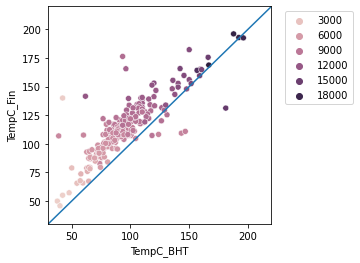

In [ ]:
# Plot BHT temperature vs "true" temperature (either static or synthetic)
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Eaglebine_Combined_stat, x="TempC_BHT", y="TempC_Fin", hue='BHT_below sea level (ft)', ax=ax)

ax.set_xlim([30, 220])
ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [ ]:
# Plot BHT, Synthetic and Static for selected wells
# 3 examples selected: 1) BHT, Synthetic and Static are present 2) BHT and Synthetic are present 3) Only BHT is available
selected_wells = [42013301930000, 42013301410000, 42013339770000]

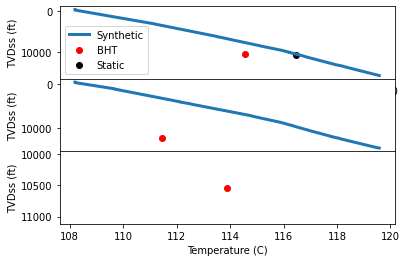

In [ ]:
# Plot selected wells using matplotlib
import matplotlib.pyplot as plt
from pylab import *

subplots_adjust(hspace=0.000)
number_of_subplots = len(selected_wells)

for i,w in enumerate(selected_wells):
    ax1 = subplot(number_of_subplots,1, i+1)

    scatter_x1 = Eaglebine_BHT.loc[Eaglebine_BHT['UWI']==w,'TempC_BHT']
    scatter_y1 = Eaglebine_BHT.loc[Eaglebine_BHT['UWI']==w,'BHT_below sea level (ft)']
    ax1.scatter(scatter_x1, scatter_y1, c='red', label='BHT')

    line_x = Eaglebine_Truth.loc[Eaglebine_Truth['UWI']==w, 'TempTrue_degC']
    line_y = Eaglebine_Truth.loc[Eaglebine_Truth['UWI']==w, 'Depth sub-sea (feet)']
    ax1.plot(line_x, line_y, lw=3, label='Synthetic' )

    scatter_x2 = Static_log_temp.loc[Static_log_temp['Well_ID']==str(w),'Temp (degC)']
    scatter_y2 = Static_log_temp.loc[Static_log_temp['Well_ID']==str(w),'Depth (ft)']
    ax1.scatter(scatter_x2, scatter_y2, c='black', label='Static')

    plt.xlabel("Temperature (C)")
    plt.ylabel("TVDss (ft)")
    plt.gca().invert_yaxis()
    if i == 0:
      plt.legend()

plt.show()

## 2.3 Process Duvernay Data

### 2.3.1 Read Duvernay Temperature Data

Read in BHT (DST) input and "true temp" synthetic data

In [ ]:
Duvernay_Truth = pd.read_excel(dir_duvernay+'Duvenay TrueTemp_Train.xlsx')
Duvernay_DST = pd.read_excel(dir_duvernay+'Duvernay DST BHT for SPE April 20 2021.xlsx')
Duvernay_Truth.head()

UWI  Depths subsea (m)  True Temperature (oC)
0  100010107020W500               -720                   2.53
1  100010107020W500               -700                   2.54
2  100010107020W500               -680                   2.54
3  100010107020W500               -660                   3.30
4  100010107020W500               -640                   4.06

In [ ]:
# add in an extra column calculating the depth sub sea (elevation-depth)*-1 
Duvernay_DST['Depth_SS(m)']=-1*(Duvernay_DST['elevation M above sea level']-(Duvernay_DST['DST Start Depth (MD) (m)']+Duvernay_DST['DST End Depth (MD) (m)'])/2)
Duvernay_DST.head()

Well ID  DST Start Depth (MD) (m)  ...               UWI  Depth_SS(m)
0  100010107020W500                    1410.6  ...  100010107020W500        716.0
1  100010608109W500                    1686.0  ...  100010608109W500       1044.4
2  100010904012W500                    3698.0  ...  100010904012W500       2424.2
3  100011206021W400                     822.0  ...  100011206021W400        171.9
4  100011506915W500                    1801.0  ...  100011506915W500        936.4

[5 rows x 13 columns]

In [ ]:
# merge BHT and "synthetic" temperature
Duvernay_Truth['TrueTemp_datasource_syn'] = 'synthetic'
Duvernay_Combined = Duvernay_DST.merge(Duvernay_Truth, on='UWI', how='left')
Duvernay_Combined.head()

Well ID  ...  TrueTemp_datasource_syn
0  100010107020W500  ...                synthetic
1  100010107020W500  ...                synthetic
2  100010107020W500  ...                synthetic
3  100010107020W500  ...                synthetic
4  100010107020W500  ...                synthetic

[5 rows x 16 columns]

In [ ]:
# keep only the synthetic model temperature data for the relevant depths for which there is BHT measurement
Duvernay_Combined['diff_depth'] = Duvernay_Combined['Depth_SS(m)']-Duvernay_Combined['Depths subsea (m)']
Duvernay_Combined['diff_depth_abs'] = np.abs(Duvernay_Combined['diff_depth'])
idx = Duvernay_Combined.groupby(['UWI'])['diff_depth_abs'].transform(min) == Duvernay_Combined['diff_depth_abs']

TrueTempUWI = Duvernay_Combined.loc[idx, ['UWI', 'diff_depth_abs', 'True Temperature (oC)', 'Depths subsea (m)', 'TrueTemp_datasource_syn']]
TrueTempUWI = TrueTempUWI.copy(deep=True)
Duvernay_Combined_cln = Duvernay_DST.merge(TrueTempUWI, on='UWI', how='left')
Duvernay_Combined_cln = Duvernay_Combined_cln.drop_duplicates(['UWI'])
Duvernay_Combined_cln.head()

Well ID  ...  TrueTemp_datasource_syn
0  100010107020W500  ...                synthetic
1  100010608109W500  ...                synthetic
2  100010904012W500  ...                      NaN
3  100011206021W400  ...                synthetic
4  100011506915W500  ...                synthetic

[5 rows x 17 columns]

### 2.3.2 Combine BHT with "true" temperature (synthetic or static)

In [ ]:
# Stat_log_temp dataframe contains Static for both Eaglebine and Duvernay
# Static_log_temp.head()
Static_log_temp.loc[Static_log_temp['Field']=="Duvernay"].head()

Well_ID  Depth (ft)  ...     Field TrueTemp_datasource_stat
19  100061706804W600     10850.0  ...  Duvernay         static_temp_logs
20  100071406220W500      9616.0  ...  Duvernay         static_temp_logs
21  100081504804W500         NaN  ...  Duvernay         static_temp_logs
22  100101606419W500      4500.0  ...  Duvernay         static_temp_logs
23  100101706419W500      4000.0  ...  Duvernay         static_temp_logs

[5 rows x 5 columns]

In [ ]:
# extract Duvernay static data and merge into Duvernay dataframe
Duvernay_Combined_cln['UWI'] = Duvernay_Combined_cln['UWI'].astype(str)
Duvernay_Combined_cln = Duvernay_Combined_cln.copy(deep=True)
# Duvernay_Combined_cln['TrueTemp_datasource_syn'] = 'synthetic'
Static_log_temp['TrueTemp_datasource_stat'] = 'static_temp_logs'
Duvernay_Combined_stat = Duvernay_Combined_cln.merge(Static_log_temp, left_on='UWI',right_on='Well_ID', how='left')

In [ ]:
# Coalesce columns together with priority for true temperature measurements
# True temperature is by default Static. If not available then use Synthetic

Duvernay_Combined_stat['TempC_Fin'] = Duvernay_Combined_stat['Temp (degC)'].fillna(Duvernay_Combined_stat['True Temperature (oC)'])
Duvernay_Combined_stat['TrueTemp_datasource'] = Duvernay_Combined_stat['TrueTemp_datasource_stat'].fillna(Duvernay_Combined_stat['TrueTemp_datasource_syn'])

Duvernay_Combined_stat.head()

Well ID  DST Start Depth (MD) (m)  ...  TempC_Fin  TrueTemp_datasource
0  100010107020W500                    1410.6  ...      60.97            synthetic
1  100010608109W500                    1686.0  ...      63.98            synthetic
2  100010904012W500                    3698.0  ...        NaN                  NaN
3  100011206021W400                     822.0  ...      39.07            synthetic
4  100011506915W500                    1801.0  ...      69.47            synthetic

[5 rows x 24 columns]

In [ ]:
Duvernay_Combined_stat.loc[Duvernay_Combined_stat['TrueTemp_datasource'].isnull()]

Well ID  DST Start Depth (MD) (m)  ...  TempC_Fin  TrueTemp_datasource
2    100010904012W500                    3698.0  ...        NaN                  NaN
8    100012404516W502                    3611.0  ...        NaN                  NaN
10   100012805703W500                    1230.0  ...        NaN                  NaN
12   100013603712W500                    1037.3  ...        NaN                  NaN
16   100020206419W500                    2484.7  ...        NaN                  NaN
..                ...                       ...  ...        ...                  ...
505  102092304009W500                    1787.0  ...        NaN                  NaN
506  102101106218W500                    3105.9  ...        NaN                  NaN
507  102101403324W400                    2403.0  ...        NaN                  NaN
508  102102106218W500                    3031.2  ...        NaN                  NaN
509  102112204416W500                    2961.0  ...        NaN                  NaN

[140 rows x 24 columns]

### 2.3.3 Add All Synthetic Data Available at Different Depth

In [ ]:
# Extra table: create Full Synthetic table with BHT information (more data points per well)
Duvernay_BHT_str = Duvernay_DST[['Well ID', 'elevation M above sea level']].copy()
Duvernay_BHT_str.rename(columns={"Well ID": "UWI"}, inplace=True)
Duvernay_BHT_str['GL_ft'] = Duvernay_BHT_str['elevation M above sea level'] *3.281

# use BHT list as master. Pull GL attribute and full synthetics
Duvernay_BHT_str = Duvernay_BHT_str.merge(Duvernay_Truth[['UWI','Depths subsea (m)','True Temperature (oC)' ]], on='UWI', how='left')


# add BHT values at appropiate depths
Duvernay_BHT_str['UWI'] = Duvernay_BHT_str['UWI'].astype(str)
selected_cols = ['UWI','Depth_SS(m)', 'DST Bottom Hole Temp. (degC)', 'Depths subsea (m)',
                 'TempC_Fin', 'TrueTemp_datasource']
Duvernay_Combined_full_synth = Duvernay_BHT_str.merge(Duvernay_Combined_stat[selected_cols], on=['UWI', 'Depths subsea (m)'], how='left')

#unit conversions
Duvernay_Combined_full_synth['GL_ft'] = Duvernay_Combined_full_synth['elevation M above sea level'] * 3.281
Duvernay_Combined_full_synth['Synth_mdSS_ft'] = Duvernay_Combined_full_synth['Depths subsea (m)'] * 3.281
Duvernay_Combined_full_synth['BHT_mdSS_ft'] = Duvernay_Combined_full_synth['Depth_SS(m)'] * 3.281
# rename and drop columns
Duvernay_Combined_full_synth.rename(columns={"True Temperature (oC)": "Synth_Value_C", 'DST Bottom Hole Temp. (degC)':'BHT_Value_C'},
                                    inplace=True)
Duvernay_Combined_full_synth.drop(Duvernay_Combined_full_synth.loc[:,['elevation M above sea level','Depths subsea (m)','Depth_SS(m)']], inplace = True, axis = 1)


# Duvernay_Combined_full_synth[~np.isnan(Duvernay_Combined_full_synth['True_Temp_C'])].tail()
Duvernay_Combined_full_synth.head()

UWI     GL_ft  ...  Synth_mdSS_ft  BHT_mdSS_ft
0  100010107020W500  2299.981  ...       -2362.32          NaN
1  100010107020W500  2299.981  ...       -2296.70          NaN
2  100010107020W500  2299.981  ...       -2231.08          NaN
3  100010107020W500  2299.981  ...       -2165.46          NaN
4  100010107020W500  2299.981  ...       -2099.84          NaN

[5 rows x 8 columns]

In [ ]:
# fill-in true temp. True temp values at any depth other than at BHT/Static, will come from the synthetic
Duvernay_Combined_full_synth['TempC_Fin'] = Duvernay_Combined_full_synth['TempC_Fin'].fillna(Duvernay_Combined_full_synth['Synth_Value_C'])

# Labeling of datasource for synthetic temperature points. "Where" condition is FALSE, labels are filled in
fill_in_condition = ~(Duvernay_Combined_full_synth['TrueTemp_datasource'].isnull()) | (Duvernay_Combined_full_synth['Synth_Value_C'].isnull())
Duvernay_Combined_full_synth['TrueTemp_datasource'] = Duvernay_Combined_full_synth['TrueTemp_datasource'].where(fill_in_condition,'synthetic')
Duvernay_Combined_full_synth.head()


UWI     GL_ft  ...  Synth_mdSS_ft  BHT_mdSS_ft
0  100010107020W500  2299.981  ...       -2362.32          NaN
1  100010107020W500  2299.981  ...       -2296.70          NaN
2  100010107020W500  2299.981  ...       -2231.08          NaN
3  100010107020W500  2299.981  ...       -2165.46          NaN
4  100010107020W500  2299.981  ...       -2099.84          NaN

[5 rows x 8 columns]

In [ ]:
Duvernay_Combined_full_synth.loc[Duvernay_Combined_full_synth['TrueTemp_datasource'].isnull()]

UWI      GL_ft  ...  Synth_mdSS_ft  BHT_mdSS_ft
234    100010904012W500  4212.1478  ...            NaN   7953.80020
1013   100012404516W502  4206.2420  ...            NaN   7654.90110
1130   100012805703W500  2309.1678  ...            NaN   1749.42920
1286   100013603712W500  4288.2670  ...            NaN   -876.51915
1729   100020206419W500  2474.2021  ...            NaN   5718.12680
...                 ...        ...  ...            ...          ...
59995  102092304009W500  3455.2211  ...            NaN   2438.93135
59996  102101106218W500  2976.1951  ...            NaN   7227.22275
59997  102101403324W400  2941.4165  ...            NaN   4965.79350
59998  102102106218W500  2883.0147  ...            NaN   7141.91675
59999  102112204416W500  3855.5031  ...            NaN   8707.44590

[140 rows x 8 columns]

### 2.3.4 Read in Duvernay mud weight, formation tops, well hearders, production summary

In [ ]:
DV_FT = pd.read_excel(dir_duvernay+"Duvernay formation tops SPE April 20 2021.xlsx")
DV_FT.columns = [c.strip() for c in DV_FT.columns.values.tolist()]
DV_FT.rename(columns = {'UWI': 'Well_Id'}, inplace = True)
display(DV_FT.head())

Well_Id  ...  17_Precambrian Basement (Surbiton)[SSTVD] (m)
0  100010107020W500  ...                                            NaN
1  100010608109W500  ...                                        -1078.4
2  100010904012W500  ...                                            NaN
3  100011206021W400  ...                                            NaN
4  100011506915W500  ...                                            NaN

[5 rows x 21 columns]

In [ ]:
# Create a Tops lookup table
DV_FT_lookup = DV_FT.copy()
DV_FT_lookup.drop(DV_FT_lookup.loc[:,'Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)':'Elevation(m above sea level)'], inplace = True, axis = 1) # remove columns not needed
DV_FT_lookup = DV_FT_lookup.melt(id_vars=["Well_Id"],var_name="Formation", value_name='Top_MD_m').sort_values(by=['Well_Id', 'Formation'])
# convert units
DV_FT_lookup.loc[:,'Top_MD_ft'] = DV_FT_lookup.loc[:,'Top_MD_m'] * 3.281*-1

DV_FT_lookup.rename(columns={'Well_Id':'UWI'}, inplace=True)
DV_FT_lookup.head()

UWI  ... Top_MD_ft
0     100010107020W500  ...       NaN
512   100010107020W500  ...       NaN
1024  100010107020W500  ... -621.7495
1536  100010107020W500  ...   11.1554
2048  100010107020W500  ...  702.1340

[5 rows x 4 columns]

In [ ]:
DV_WH = pd.read_excel(dir_duvernay+"Duvernay well headers SPE April 21 2021 .xlsx")
display(DV_WH.head())
DV_WH.columns = [c.strip() for c in DV_WH.columns.values.tolist()]
DV_WH.rename(columns = {'UWI': 'Well_Id'}, inplace = True)

UWI   ...  BottomLongitude_NAD27
0  100072507623W500  ...            -117.423800
1  100062007823W500  ...            -117.537674
2  100052107723W500  ...            -117.516168
3  100061307518W500  ...            -116.653606
4  100070907618W500  ...            -116.726243

[5 rows x 12 columns]

In [ ]:
DV_PS = pd.read_excel(dir_duvernay+"SPE Duvernay production summary April 20 2021.xlsx")
display(DV_PS.head())
DV_PS.columns = [c.strip() for c in DV_PS.columns.values.tolist()]
DV_PS.rename(columns = {'API': 'Well_Id'}, inplace = True)

API     ...  Yield Total Average   
0  100010107020W500  ...                     NaN
1  100010608109W500  ...                1256.918
2  100010904012W500  ...                     NaN
3  100011206021W400  ...                     NaN
4  100011506915W500  ...                     NaN

[5 rows x 24 columns]

### 2.3.5 Extract Duvernay data key features

In [ ]:
# Bring-in Full Synthetics table and Tops. Filter-in only depths of interest (file is too large)

# Bring in Full synthetics table and Tops
DV_FT_str = DV_FT.copy()
DV_FT_str.rename(columns = {'Well_Id': 'UWI'}, inplace = True)
GTX_features_DV = Duvernay_Combined_full_synth.merge(DV_FT_str, on=['UWI'], how='left')

# convert units
GTX_features_DV.loc[:,'01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'] = GTX_features_DV.loc[:,'01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'] * 3.281*-1

GTX_features_DV.drop(GTX_features_DV.loc[:,'Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)':'Elevation(m above sea level)'], inplace = True, axis = 1)

GTX_features_DV.tail()

UWI  ...  17_Precambrian Basement (Surbiton)[SSTVD] (m)
60294  106141105522W400  ...                                            NaN
60295  106141105522W400  ...                                            NaN
60296  106141105522W400  ...                                            NaN
60297  106141105522W400  ...                                            NaN
60298  106141105522W400  ...                                            NaN

[5 rows x 25 columns]

In [ ]:
# Pull lat, long, KB from wellhead table


DV_WH['Well_Id'] = DV_WH['Well_Id'].astype(str)
selected_cols = ['Well_Id','BottomLatitude_NAD83', 'BottomLongitude_NAD83', 'Elevation Meters']
GTX_features_DV = GTX_features_DV.merge(DV_WH[selected_cols], left_on=['UWI'], right_on=['Well_Id'], how='left')

GTX_features_DV['KB_ft'] = GTX_features_DV['Elevation Meters']*3.281
GTX_features_DV.drop(['Well_Id', 'Elevation Meters'], inplace = True, axis = 1) # remove extra columns not needed

GTX_features_DV.rename(columns = {'BottomLatitude_NAD83': 'Lat', 'BottomLongitude_NAD83':'Long'}, inplace = True)

In [ ]:
GTX_features_DV.head()

UWI     GL_ft  ...        Long        KB_ft
0  100010107020W500  2299.981  ... -116.903553  2300.287711
1  100010107020W500  2299.981  ... -116.903553  2300.287711
2  100010107020W500  2299.981  ... -116.903553  2300.287711
3  100010107020W500  2299.981  ... -116.903553  2300.287711
4  100010107020W500  2299.981  ... -116.903553  2300.287711

[5 rows x 28 columns]

In [ ]:
# Add column DEPTH coalescing the depth of the Synthetic and the depth of the BHT - where Synth depth not available use BHT
GTX_features_DV['Depth_mdSS_ft'] = GTX_features_DV['Synth_mdSS_ft'].mask(pd.isnull, GTX_features_DV['BHT_mdSS_ft'])
GTX_features_DV['Depth_mdKB_ft'] = GTX_features_DV['Depth_mdSS_ft'] + GTX_features_DV['KB_ft'] # calculate KB depth (FT tops are in mdKB)

GTX_features_DV.replace(0, np.nan, inplace=True) # replace tops with zero by nans

# Filter-in only SYNTH depths of interest 
buffer = 100 # set big enough so all 512 are kept in the dataset
GTX_features_DV['min_depth'] = GTX_features_DV.loc[:,'01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'].min(axis=1) # shallowest formation depth
GTX_features_DV['max_depth'] = GTX_features_DV.loc[:,'01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'].max(axis=1) # deepest formation depth
filter_criteria = ((GTX_features_DV['Depth_mdSS_ft'] >= (GTX_features_DV['min_depth']-buffer)) & (GTX_features_DV['Depth_mdSS_ft'] <= GTX_features_DV['max_depth']+buffer)&
                (GTX_features_DV['TrueTemp_datasource']=='synthetic')) | (GTX_features_DV['TrueTemp_datasource']!='synthetic')
GTX_features_DV = GTX_features_DV[filter_criteria]

In [ ]:
GTX_features_DV.head()

UWI     GL_ft  ...  min_depth  max_depth
26  100010107020W500  2299.981  ...  -621.7495  6707.3483
27  100010107020W500  2299.981  ...  -621.7495  6707.3483
28  100010107020W500  2299.981  ...  -621.7495  6707.3483
29  100010107020W500  2299.981  ...  -621.7495  6707.3483
30  100010107020W500  2299.981  ...  -621.7495  6707.3483

[5 rows x 32 columns]

In [ ]:
GTX_features_DV.loc[GTX_features_DV['TrueTemp_datasource'].isnull()]

UWI      GL_ft  ...   min_depth   max_depth
234    100010904012W500  4212.1478  ...  3549.35299  11498.9207
1013   100012404516W502  4206.2420  ...  3442.09710  11254.8143
1130   100012805703W500  2309.1678  ...  -655.54380   4695.7672
1286   100013603712W500  4288.2670  ... -2896.46680  -1083.0581
1729   100020206419W500  2474.2021  ...   467.87060   7064.3211
...                 ...        ...  ...         ...         ...
59995  102092304009W500  3455.2211  ...  2762.93010   9449.2800
59996  102101106218W500  2976.1951  ...   425.87380   7419.3253
59997  102101403324W400  2941.4165  ...   -73.82250   5267.6455
59998  102102106218W500  2883.0147  ...   668.01160   7451.4791
59999  102112204416W500  3855.5031  ...  3959.83890  11799.7884

[140 rows x 32 columns]

In [ ]:
GTX_features_DV.groupby(['UWI']).ngroups

512

In [ ]:
# Calculate top formation name at each depth
Tops = GTX_features_DV.loc[:, '01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'].sub(GTX_features_DV['Depth_mdSS_ft'], axis='index')*-1 
Tops[Tops < 0] = np.nan
GTX_features_DV['Formation1'] = Tops.idxmin(axis="columns")

GTX_features_DV.head()

UWI  ...                                         Formation1
26  100010107020W500  ...                                                NaN
27  100010107020W500  ...  03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)
28  100010107020W500  ...  03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)
29  100010107020W500  ...  03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)
30  100010107020W500  ...  03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)

[5 rows x 33 columns]

In [ ]:
# Calculate bottom formation name at each depth
Bottom = GTX_features_DV.loc[:, '01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'].sub(GTX_features_DV['Depth_mdSS_ft'], axis='index')*-1
Bottom[Bottom > 0] = np.nan
GTX_features_DV['Formation2'] = Bottom.idxmax(axis="columns")

GTX_features_DV.head()

UWI  ...                                         Formation2
26  100010107020W500  ...  03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)
27  100010107020W500  ...  04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)
28  100010107020W500  ...  04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)
29  100010107020W500  ...  04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)
30  100010107020W500  ...  04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)

[5 rows x 34 columns]

In [ ]:
# Calculate Formation top/bottom values

# if formation1 not present do formation2 as imputation
GTX_features_DV['Formation_est'] = GTX_features_DV['Formation1'].fillna(GTX_features_DV['Formation2'])

# get top formation1
GTX_features_DV = GTX_features_DV.merge(DV_FT_lookup, left_on=['UWI', 'Formation1'],right_on=['UWI', 'Formation'], how='left')

#get top formation 2
GTX_features_DV = GTX_features_DV.merge(DV_FT_lookup, left_on=['UWI', 'Formation2'], right_on=['UWI', 'Formation'], how='left')
GTX_features_DV.rename(columns={'Top_MD_ft_x':'Top_mdSS_ft', 'Top_MD_ft_y':'Bottom_mdSS_ft'}, inplace=True) # set names for TOP and BOTTOM
GTX_features_DV.rename(columns={'Formation_est':'Formation'}, inplace=True) # set names for Formation field

# cleanup
GTX_features_DV.drop(['min_depth','max_depth', 'Formation1', 'Formation2'], inplace = True, axis = 1) # remove extra columns not needed
GTX_features_DV.drop(['Formation_x', 'Formation_y', 'Top_MD_m_x', 'Top_MD_m_y'], inplace = True, axis = 1) # remove extra columns not needed
GTX_features_DV.drop(GTX_features_DV.loc[:,'01_Battle (Surbiton)[SSTVD] (m)':'17_Precambrian Basement (Surbiton)[SSTVD] (m)'], inplace = True, axis = 1) # remove extra columns not needed

GTX_features_DV.head()

UWI     GL_ft  ...  Top_mdSS_ft  Bottom_mdSS_ft
0  100010107020W500  2299.981  ...          NaN       -621.7495
1  100010107020W500  2299.981  ...    -621.7495         11.1554
2  100010107020W500  2299.981  ...    -621.7495         11.1554
3  100010107020W500  2299.981  ...    -621.7495         11.1554
4  100010107020W500  2299.981  ...    -621.7495         11.1554

[5 rows x 16 columns]

In [ ]:
# assign column names
col_names = ['UWI', 'GL_ft', 'Synth_Value_C','BHT_Value_C','True_Temp_C','True_Temp_Source','Synth_Depth_mdSS_ft', 'BHT_Depth_mdSS_ft', 'Lat', 'Long', 'KB_ft', 
              'Depth_mdSS_ft','Depth_mdKB_ft', 'Formation','Top_mdSS_ft',  'Bottom_mdSS_ft'
            ]
GTX_features_DV.columns = col_names
GTX_features_DV.head()

UWI     GL_ft  ...  Top_mdSS_ft  Bottom_mdSS_ft
0  100010107020W500  2299.981  ...          NaN       -621.7495
1  100010107020W500  2299.981  ...    -621.7495         11.1554
2  100010107020W500  2299.981  ...    -621.7495         11.1554
3  100010107020W500  2299.981  ...    -621.7495         11.1554
4  100010107020W500  2299.981  ...    -621.7495         11.1554

[5 rows x 16 columns]

In [ ]:
col_names_sorted = ['UWI', 'GL_ft', 'KB_ft', 'Depth_mdSS_ft', 'Depth_mdKB_ft', 'Formation', 'Top_mdSS_ft', 'Bottom_mdSS_ft', 'Lat', 'Long', 'True_Temp_C', 'True_Temp_Source', 
                    'Synth_Depth_mdSS_ft', 'Synth_Value_C', 'BHT_Depth_mdSS_ft', 'BHT_Value_C'
            ]
GTX_features_DV = GTX_features_DV[col_names_sorted]
GTX_features_DV.head()

UWI     GL_ft  ...  BHT_Depth_mdSS_ft  BHT_Value_C
0  100010107020W500  2299.981  ...                NaN          NaN
1  100010107020W500  2299.981  ...                NaN          NaN
2  100010107020W500  2299.981  ...                NaN          NaN
3  100010107020W500  2299.981  ...                NaN          NaN
4  100010107020W500  2299.981  ...                NaN          NaN

[5 rows x 16 columns]

### 2.3.6 Plot Duvernay Data

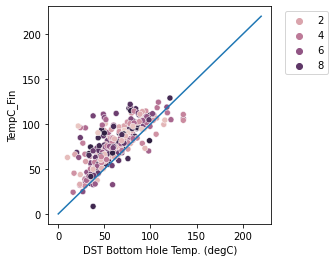

In [ ]:
import matplotlib.pyplot as plt
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=Duvernay_Combined_stat, 
                x="DST Bottom Hole Temp. (degC)",
                y="TempC_Fin",
                hue='diff_depth_abs', ax=ax)

#ax.set_xlim([30, 220])
#ax.set_ylim([30, 220])
ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 2.4 Combine Eaglebine and Duvernay datasets

In [ ]:
GTX_features_EB['Field'] = 'Eaglebine'
GTX_features_DV['Field'] = 'Duvernay'
GTX_features = pd.concat((GTX_features_EB, GTX_features_DV))
# GTX_features = GTX_features.dropna(subset=['True_Temp_C','BHT_Value' ]) # remove rows with no True temp
GTX_features.head()

UWI  GL_ft  KB_ft  ...  BHT_Value_C  Time_SC_hrs      Field
0  42013301410000  345.9  328.0  ...          NaN          NaN  Eaglebine
1  42013301410000  345.9  328.0  ...          NaN          NaN  Eaglebine
2  42013301410000  345.9  328.0  ...          NaN          NaN  Eaglebine
3  42013301410000  345.9  328.0  ...          NaN          NaN  Eaglebine
4  42013301410000  345.9  328.0  ...          NaN          NaN  Eaglebine

[5 rows x 20 columns]

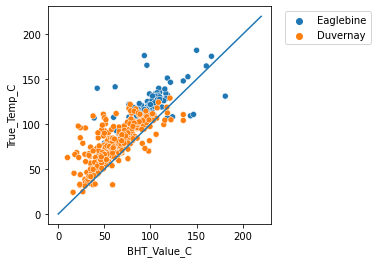

In [ ]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.scatterplot(data=GTX_features, 
                x="BHT_Value_C",
                y="True_Temp_C",
                hue='Field', ax=ax)

ax.plot([0, 220], [0, 220])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## 2.5 Organize LAS file data

### 2.5.1 Read in LAS files

In [ ]:
### Thanks to Pushpesh Sharma for writing this section

In [ ]:
import os
!pip install lasio
import lasio

In [ ]:
#Load all files at once into las and las_df to save time
folder='/content/drive/MyDrive/Colab Notebooks/0_Data/well_log_files/Clean_LAS/'
all_files = os.listdir(folder)
n_files = len(all_files)

bad_files = []

las = {}
las_df = {}
mnemonics ={}
i=0
for filename in tqdm(os.listdir(folder)):
    i=i+1
    if filename.endswith(".LAS"):
        las[filename] = lasio.read(folder+'/'+filename)
        las_df[filename] = las[filename].df()
        mnemonics[filename] = las_df[filename].columns

In [ ]:
# make a table of the log types available per well
for filename in all_files:
    las_df[filename] = las_df[filename].rename_axis('DEPT').reset_index()

In [ ]:
#find out which well curves/logs are in each las file
listDF = []
for filename in tqdm(all_files):
    df = pd.DataFrame(columns = list(mnemonics[filename]), data = np.ones((1,len(mnemonics[filename]))))
    df['well_name']=filename
    listDF.append(df)

In [ ]:
log_table=pd.concat(listDF)

In [ ]:
# Here we can see which logs are in each well
log_table.tail()

CALD  CALS  CILD  DPHI_LS  ...  ENPHLSED  ENPHSSED  ENPH_LS  ENPH_SS
0   1.0   1.0   NaN      1.0  ...       NaN       NaN      NaN      NaN
0   NaN   NaN   NaN      NaN  ...       NaN       NaN      NaN      NaN
0   NaN   NaN   NaN      NaN  ...       NaN       NaN      NaN      NaN
0   NaN   NaN   NaN      NaN  ...       NaN       NaN      NaN      NaN
0   NaN   NaN   NaN      NaN  ...       NaN       NaN      NaN      NaN

[5 rows x 794 columns]

In [ ]:
# add column to log_table indicating whether well is in Eaglebine or Duvernay
basin = []

for index, row in log_table.iterrows():
  filename = row['well_name']
  country = filename[0:2]
  if country == 'US':
    wellname = filename[2:16] # US wellnames have 14 characters
    if wellname not in GTX_features_EB.UWI.values: # well is not of interest (no BHT), move on to next well
      basin.append(np.nan)
    else:
      basin.append('Eaglebine')
  else:
    wellname = filename[2:18] # Canadian wellnames have 16 characters
    if wellname not in GTX_features_DV.UWI.values: # well is not of interest (no BHT), move on to next well
      basin.append(np.nan)
    else:
      basin.append('Duvernay')

log_table['basin'] = basin

log_table.tail()

CALD  CALS  CILD  DPHI_LS  ...  ENPHSSED  ENPH_LS  ENPH_SS     basin
0   1.0   1.0   NaN      1.0  ...       NaN      NaN      NaN  Duvernay
0   NaN   NaN   NaN      NaN  ...       NaN      NaN      NaN  Duvernay
0   NaN   NaN   NaN      NaN  ...       NaN      NaN      NaN  Duvernay
0   NaN   NaN   NaN      NaN  ...       NaN      NaN      NaN  Duvernay
0   NaN   NaN   NaN      NaN  ...       NaN      NaN      NaN  Duvernay

[5 rows x 795 columns]

In [ ]:
# Calculate log totals per basin
log_table = log_table.groupby(['basin']).sum().T
log_table['Total'] = log_table['Duvernay'] + log_table['Eaglebine']
log_table.head()

basin    Duvernay  Eaglebine  Total
CALD        211.0      140.0  351.0
CALS        321.0       23.0  344.0
CILD        219.0       57.0  276.0
DPHI_LS     198.0      109.0  307.0
DPHI_SS     175.0       71.0  246.0

In [ ]:
# Select top 'n' logs and put in list
n = 5
log_table = log_table.nlargest(n,'Total')
WellLog = log_table.index.values.tolist()
# print(WellLog)
log_table

basin   Duvernay  Eaglebine  Total
SPR        496.0      301.0  797.0
GRWS       510.0      150.0  660.0
DRESWS     507.0      150.0  657.0
CONDWS     506.0      150.0  656.0
CALWS      503.0      147.0  650.0

### 2.5.2 Calculate Petrophysical summaries at formation of interest

In [ ]:
# Extract petrophysical summaries from LAS files, for the section of interest in each well (formation where BHT was taken)
# you can specify a list of logs to extract. Currently the list contains top 5 most popular logs: SPR, GRWS, DRESWS, CONDWS, CALWS 

import math

# WellLog = ['SPR', 'GRWS', 'DRESWS', 'CONDWS', 'CALWS']

new_las_df = {}
extracted_df = {}
j = 0

for filename in tqdm(all_files):
    country = filename[0:2]
    if country == 'US':
      wellname = filename[2:16] # US wellnames have 14 characters
    else:
      wellname = filename[2:18] # Canadian wellnames have 16 characters

    if wellname not in GTX_features.UWI.values: # well is not of interest (no BHT), move on to next well
      continue

    # extract dataframe with all logs for well, sort depth
    p = las_df[filename].sort_values(by='DEPT') 
    log_units = las[filename].curves.DEPT.unit
    if log_units == 'M': # if log depth is in metric units convert to ft
      p['DEPT'] *= 3.281

    present_WellLog = [] # create list of logs of interest present in current well
    for log in WellLog:
      if log in list(p.columns):
        present_WellLog.append(log)
      
    if(not present_WellLog): # no logs of interest in current well, list is empty, move on to next well
      continue

    for index, row in GTX_features.loc[(GTX_features['UWI']==wellname),:].iterrows(): 
      # get top, bottom depths of BHT measurement in mdKB. Assumes all logs are referenced to KB
      temp_depth = row['Depth_mdKB_ft']
      top_depth = temp_depth - 50
      bottom_depth = temp_depth + 50

      # filter in only log depths of interest
      if math.isnan(top_depth): 
        q = p[(p['DEPT'] < bottom_depth)]
      elif math.isnan(bottom_depth):
        q = p[(p['DEPT'] >= top_depth)]
      else:
        q = p[(p['DEPT'] >= top_depth) & (p['DEPT'] < bottom_depth)] 

      if q.empty: # skip, interval not present in logs
        continue

      # present_WellLog.append('DEPT') # add Depth track
      select_cols = present_WellLog+['DEPT']

      df = q[select_cols].copy() # extract log tracks present in list WellLog
      df['UWI'] = wellname # add column with UWI extracted from file name
      df['FileName'] = filename
      df['Country'] = country
      df['Depth_mdKB_ft'] = temp_depth

      if filename[-5] == 'W': # add labels or clean or raw added depending on whether file name has letter W
        df['LogType'] = 'Cleaned'
      else:
        df['LogType'] = 'Raw'

      extracted_df[j] = df # dictionary of dataframes, one per well
      j = j+1



In [ ]:
# concatenate dataframes in dictionary
LargeDF = pd.concat(extracted_df, ignore_index=True) 
# LargeDF.to_csv('StructuredData/LogData.csv')
LargeDF.head()

GRWS   DRESWS    CONDWS     CALWS  ...  Country Depth_mdKB_ft  LogType SPR
0  74.0624  18.4710   54.1389   10.1970  ...       CA   5454.057454  Cleaned NaN
1  95.6084  11.0628   90.3930   11.2566  ...       CA   5454.057454  Cleaned NaN
2  46.4905   3.2009  312.4121  219.0277  ...       CA    979.050400  Cleaned NaN
3  59.7573   3.3903  294.9591  263.0707  ...       CA   1110.290400  Cleaned NaN
4  59.7573   3.3903  294.9591  263.0707  ...       CA   1175.910400  Cleaned NaN

[5 rows x 11 columns]

In [ ]:
# calculate petrophysical summaries in section of interest using Mean
pp_summary_at_Fm = LargeDF.groupby(['UWI', 'Depth_mdKB_ft']).mean()
pp_summary_at_Fm.drop(columns=['DEPT'], inplace=True)

# pp_summary_at_Fm.head()

### 2.5.3 Add petrophysical summaries to key features table and export to csv

In [ ]:
# Add petrophysical summaries to GTX_features table
GTX_features = GTX_features.merge(pp_summary_at_Fm, on=['UWI','Depth_mdKB_ft'], how='left')

In [ ]:
GTX_features.head()

UWI  GL_ft  KB_ft  Depth_mdSS_ft  ...   DRESWS     CONDWS  CALWS   SPR
0  42013301410000  345.9  328.0         1400.0  ...  5.76865  174.17130    NaN -41.6
1  42013301410000  345.9  328.0         1450.0  ...  6.18790  161.60800    NaN -40.2
2  42013301410000  345.9  328.0         1500.0  ...  5.62890  179.57635    NaN -35.3
3  42013301410000  345.9  328.0         1550.0  ...  6.59160  160.52735    NaN -34.5
4  42013301410000  345.9  328.0         1600.0  ...  6.28105  174.43235    NaN -34.0

[5 rows x 25 columns]

In [ ]:
GTX_features[GTX_features['UWI']=='42507312420000']

UWI  GL_ft  KB_ft  ...  CONDWS  CALWS       SPR
16567  42507312420000  660.7  642.0  ...     NaN    NaN -18.27125

[1 rows x 25 columns]

In [85]:
GTX_features.to_csv(dir_notebook+'GTX_features_full_synthetic.csv', index=False)

# 3.0 Feature Engineering

## 3.1 Read in Features Dataset

In [87]:
GTX_features = pd.read_csv(dir_notebook+'GTX_features_full_synthetic.csv')
GTX_features.head(5)

UWI  GL_ft  KB_ft  ...  BHT_Depth_mdKB_ft  Formation_enc Field_enc
0  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
1  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
2  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
3  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
4  42013301410000  345.9  328.0  ...                NaN            1.0       1.0

[5 rows x 34 columns]

In [88]:
GTX_features.dtypes

UWI                     object
GL_ft                  float64
KB_ft                  float64
Depth_mdSS_ft          float64
Depth_mdKB_ft          float64
Formation               object
Top_mdSS_ft            float64
Bottom_mdSS_ft         float64
Mud_Weight_ppg         float64
Lat                    float64
Long                   float64
True_Temp_C            float64
True_Temp_Source        object
Synth_Depth_mdSS_ft    float64
Synth_Value_C          float64
BHT_Depth_mdSS_ft      float64
BHT_Depth_mdGL_ft      float64
BHT_Value_C            float64
Time_SC_hrs            float64
Field                   object
GRWS                   float64
DRESWS                 float64
CONDWS                 float64
CALWS                  float64
SPR                    float64
BHT_correction_C       float64
BHT_correction_pct     float64
Temp_Gradient_C_Km     float64
Synth_Depth_mdKB_ft    float64
Synth_Depth_mdGL_ft    float64
Depth_mdGL_ft          float64
BHT_Depth_mdKB_ft      float64
Formatio

## 3.2 Add-in some Engineered Features

In [89]:
# Add some calculated features
GTX_features['BHT_correction_C'] = GTX_features['Synth_Value_C'] - GTX_features['BHT_Value_C']
GTX_features['BHT_correction_pct'] = ((GTX_features['Synth_Value_C'] / GTX_features['BHT_Value_C']) - 1)

GTX_features['BHT_Depth_mdGL_ft'] = GTX_features['BHT_Depth_mdSS_ft'] + GTX_features['GL_ft']
GTX_features['Temp_Gradient_C_Km'] = (GTX_features['Synth_Value_C'] - 38)/(GTX_features['BHT_Depth_mdGL_ft']/3.281/1000)
GTX_features['Synth_Depth_mdKB_ft'] = GTX_features['Synth_Depth_mdSS_ft'] + GTX_features['KB_ft']
GTX_features['Synth_Depth_mdGL_ft'] = GTX_features['Synth_Depth_mdSS_ft'] + GTX_features['GL_ft']
GTX_features['Depth_mdGL_ft'] = GTX_features['Depth_mdSS_ft'] + GTX_features['GL_ft']
GTX_features['BHT_Depth_mdKB_ft'] = GTX_features['BHT_Depth_mdSS_ft'] + GTX_features['KB_ft']

In [90]:
GTX_features.head()

UWI  GL_ft  KB_ft  ...  BHT_Depth_mdKB_ft  Formation_enc Field_enc
0  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
1  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
2  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
3  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
4  42013301410000  345.9  328.0  ...                NaN            1.0       1.0

[5 rows x 34 columns]

In [91]:
# create encoded dataset version of categorical variables (used for KNN imputation) 
GTX_features_enc = GTX_features.copy(deep=True)

In [92]:
from sklearn.preprocessing import OrdinalEncoder

#instantiate both packages to use
encoder = OrdinalEncoder()
# imputer = KNN()


# create a list of categorical columns to iterate over
cat_cols = ['Formation','Field']
cat_cols_enc = ['Formation_enc','Field_enc']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(GTX_features_enc[columns])

In [93]:
# Do imputation on missing Lat, Long
from sklearn.impute import KNNImputer

imp_cols = ['Lat', 'Long']
# imr = KNNImputer(n_neighbors=2, weights="uniform")
imr = KNNImputer()
imp_by_cols = cat_cols + imp_cols
enc_cols = cat_cols_enc + imp_cols

GTX_features[enc_cols] = pd.DataFrame(imr.fit_transform(GTX_features_enc[imp_by_cols]), columns = imp_by_cols).to_numpy()

GTX_features.head()

UWI  GL_ft  KB_ft  ...  BHT_Depth_mdKB_ft  Formation_enc Field_enc
0  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
1  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
2  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
3  42013301410000  345.9  328.0  ...                NaN            1.0       1.0
4  42013301410000  345.9  328.0  ...                NaN            1.0       1.0

[5 rows x 34 columns]

## 3.3 Create Training/Validation sets

In [95]:
# read in Datahon's validation well list
set_split = pd.read_csv(dir_main+'set_assign.csv')
set_split.head()

UWI                 Set
0    42021301990000  Validation_Testing
1  100102606420W500  Validation_Testing
2  100141705519W500  Validation_Testing
3  100141503621W400  Validation_Testing
4  100043406718W500  Validation_Testing

In [96]:
# add column with flag indicating whether well is used for training or for validation
GTX_features_set = GTX_features.merge(set_split, on='UWI', how='left')
GTX_features_set.head()

UWI  GL_ft  KB_ft  ...  Formation_enc  Field_enc  Set
0  42013301410000  345.9  328.0  ...            1.0        1.0  NaN
1  42013301410000  345.9  328.0  ...            1.0        1.0  NaN
2  42013301410000  345.9  328.0  ...            1.0        1.0  NaN
3  42013301410000  345.9  328.0  ...            1.0        1.0  NaN
4  42013301410000  345.9  328.0  ...            1.0        1.0  NaN

[5 rows x 35 columns]

In [97]:
# split dataset into the Training wells and the Validation wells
filterTraining = GTX_features_set['Set']=='Training'
GTX_features_set[filterTraining].to_csv(dir_notebook+'GTX_dataset_training.csv', index=False)

filterTesting = GTX_features_set['Set']=='Validation_Testing'
GTX_features_set[filterTesting].to_csv(dir_notebook+'GTX_dataset_validation.csv', index=False)

In [98]:
# load dataset with wells to be used for training the model
train = pd.read_csv(dir_notebook+'GTX_dataset_training.csv')

In [ ]:
train.head()

UWI  GL_ft  KB_ft  ...  Formation_enc  Field_enc       Set
0  42013301410000  345.9  328.0  ...            1.0        1.0  Training
1  42013301410000  345.9  328.0  ...            1.0        1.0  Training
2  42013301410000  345.9  328.0  ...            1.0        1.0  Training
3  42013301410000  345.9  328.0  ...            1.0        1.0  Training
4  42013301410000  345.9  328.0  ...            1.0        1.0  Training

[5 rows x 35 columns]

# 4.0 EDA

##4.1 Geographical Distribution of Wells

In [ ]:
GTX_features.describe(include='all')

UWI         GL_ft  ...  Formation_enc     Field_enc
count            56184  56184.000000  ...   56184.000000  56184.000000
unique             836           NaN  ...            NaN           NaN
top     42013301410000           NaN  ...            NaN           NaN
freq               229           NaN  ...            NaN           NaN
mean               NaN   2121.517000  ...      14.677043      0.296472
std                NaN   1152.160036  ...       9.181575      0.456706
min                NaN    195.150000  ...       0.000000      0.000000
25%                NaN    554.900000  ...       6.000000      0.000000
50%                NaN   2577.225500  ...      12.000000      0.000000
75%                NaN   2985.053800  ...      23.000000      1.000000
max                NaN   5393.307800  ...      35.000000      1.000000

[11 rows x 34 columns]

In [ ]:
Selected_for_plot=GTX_features[['UWI', 'Lat', 'Long', 'Field', 'Depth_mdSS_ft', 'Depth_mdKB_ft', 'BHT_Depth_mdSS_ft', 'BHT_Depth_mdKB_ft', 'Depth_mdGL_ft', 'BHT_Value_C', 'True_Temp_C', 'Time_SC_hrs']]
Selected_for_plot=Selected_for_plot.copy(deep=True)

In [ ]:
Selected_for_plot=Selected_for_plot.loc[Selected_for_plot.groupby(['UWI']).Depth_mdGL_ft.idxmax()]

In [ ]:
Selected_for_plot['Depth_mdGL_m']=Selected_for_plot.Depth_mdGL_ft*0.3048

In [ ]:
Selected_for_plot.describe()

Lat        Long  ...  Time_SC_hrs  Depth_mdGL_m
count  836.000000  836.000000  ...    75.000000    836.000000
mean    44.819556 -108.787094  ...     7.479333   2746.101181
std     11.882860    9.179641  ...     5.256904    765.454451
min     27.975343 -119.010002  ...     2.000000    526.125674
25%     30.496331 -116.561791  ...     4.875000   2267.274703
50%     53.424134 -115.105663  ...     6.000000   2768.642067
75%     54.539809  -97.509073  ...     8.000000   3272.317560
max     56.050945  -95.623436  ...    33.200000   5128.450256

[8 rows x 11 columns]

In [ ]:
location=[Selected_for_plot.Lat.mean(), Selected_for_plot.Long.mean()]

In [ ]:

map= folium.Map(location=location, zoom_start=4,tiles='Stamen Toner')

lat = list(Selected_for_plot.Lat)
lon = list(Selected_for_plot.Long)
gra = list(Selected_for_plot.Field.replace({'Eaglebine':'Blue', 'Duvernay':'Red'}))

for loc, gra in zip(zip(lat, lon), gra):
  folium.Circle(loc, radius=40,fill=True,             
                color=gra,
                popup=str(gra),
                opacity=0.5,
                fill_opacity=.5
                ).add_to(map)


#folium.LayerControl().add_to(map)

#Add legend

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Field</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Duvernay</li>
    <li><span style='background:blue;opacity:0.7;'></span>Eaglebine</li>


  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map.get_root().add_child(macro)


display(map)

Well Depth

In [ ]:
vmin=Selected_for_plot['Depth_mdGL_m'].min()
vmax=Selected_for_plot['Depth_mdGL_m'].max()

cmap = matplotlib.cm.get_cmap('RdBu_r')
rgba=[]
for i in range(cmap.N):
    rgba.append(cmap(i))

levels=14
colormap = cmp.LinearColormap(
    rgba,
    vmin=vmin, vmax=vmax,
    caption='Depth from Ground Level (m)' #Caption for Color scale or Legend
)

map= folium.Map(location=location, zoom_start=4, tiles='Stamen Toner')

lat = list(Selected_for_plot.Lat)
lon = list(Selected_for_plot.Long)
gra = list(Selected_for_plot.Depth_mdGL_m)


plugins.Fullscreen(position='topright', force_separate_button=True).add_to(map)

for loc, gra in zip(zip(lat, lon), gra):
  folium.Circle(loc, radius=40,fill=True,
                #color='black',
                color=colormap(gra),
                popup=str(gra),
                opacity=1,
                ).add_to(map)


map.add_child(colormap)
display(map)

##4.2 Generating Profile

In [ ]:
!pip install pandas-profiling==2.8.0

In [ ]:
GTX_features.columns

Index(['UWI', 'GL_ft', 'KB_ft', 'Depth_mdSS_ft', 'Depth_mdKB_ft', 'Formation',
       'Top_mdSS_ft', 'Bottom_mdSS_ft', 'Mud_Weight_ppg', 'Lat', 'Long',
       'True_Temp_C', 'True_Temp_Source', 'Synth_Depth_mdSS_ft',
       'Synth_Value_C', 'BHT_Depth_mdSS_ft', 'BHT_Depth_mdGL_ft',
       'BHT_Value_C', 'Time_SC_hrs', 'Field', 'GRWS', 'DRESWS', 'CONDWS',
       'CALWS', 'SPR', 'BHT_correction_C', 'BHT_correction_pct',
       'Temp_Gradient_C_Km', 'Synth_Depth_mdKB_ft', 'Synth_Depth_mdGL_ft',
       'Depth_mdGL_ft', 'BHT_Depth_mdKB_ft', 'Formation_enc', 'Field_enc'],
      dtype='object')

In [50]:
Selected_for_feature=GTX_features[['UWI', 'Field','Lat', 'Long','BHT_Value_C','True_Temp_C',
       'Temp_Gradient_C_Km', 'Synth_Depth_mdKB_ft','Formation',
       'Mud_Weight_ppg',  'Synth_Depth_mdSS_ft','Time_SC_hrs',  'GRWS', 'DRESWS', 'CONDWS',
       'CALWS', 'SPR']]
Selected_for_feature=Selected_for_feature.copy(deep=True)

In [53]:
Selected_for_feature=Selected_for_feature[Selected_for_feature.BHT_Value_C.notna()]

In [54]:
Selected_for_feature.describe()

Lat        Long  BHT_Value_C  ...      CONDWS       CALWS         SPR
count  757.000000  757.000000   757.000000  ...  496.000000  488.000000  585.000000
mean    45.980251 -109.683409    71.330910  ...  107.113275   53.681744  -74.210237
std     11.564789    8.937407    26.983780  ...  122.291712   91.318154   54.568806
min     27.975343 -119.010002    10.000000  ...    0.065750    5.243900 -337.963050
25%     30.564036 -116.597555    50.000000  ...   21.089400    8.722988 -105.671600
50%     53.720232 -115.325226    70.000000  ...   68.224975    9.616475  -62.337550
75%     54.576006  -98.113381    88.890000  ...  149.184213   11.812663  -35.239650
max     56.050945  -95.623436   185.555556  ...  929.181850  382.806700   69.475900

[8 rows x 14 columns]

In [ ]:
from pandas_profiling import ProfileReport

In [55]:
profile = ProfileReport(Selected_for_feature, title="Selected_for_feature")

In [56]:
profile

Output hidden; open in https://colab.research.google.com to view.

##4.3 Pair Plot

In [46]:
Selected_for_pair=GTX_features[['UWI', 'Field','BHT_Value_C','True_Temp_C', 
       'Temp_Gradient_C_Km', 'BHT_Depth_mdKB_ft','Synth_Depth_mdKB_ft',
       'Mud_Weight_ppg',  'Synth_Depth_mdSS_ft','Time_SC_hrs']]
Selected_for_pair=Selected_for_pair.copy(deep=True)

In [44]:
Selected_for_pair=Selected_for_pair[Selected_for_pair.BHT_Value_C.notna()]

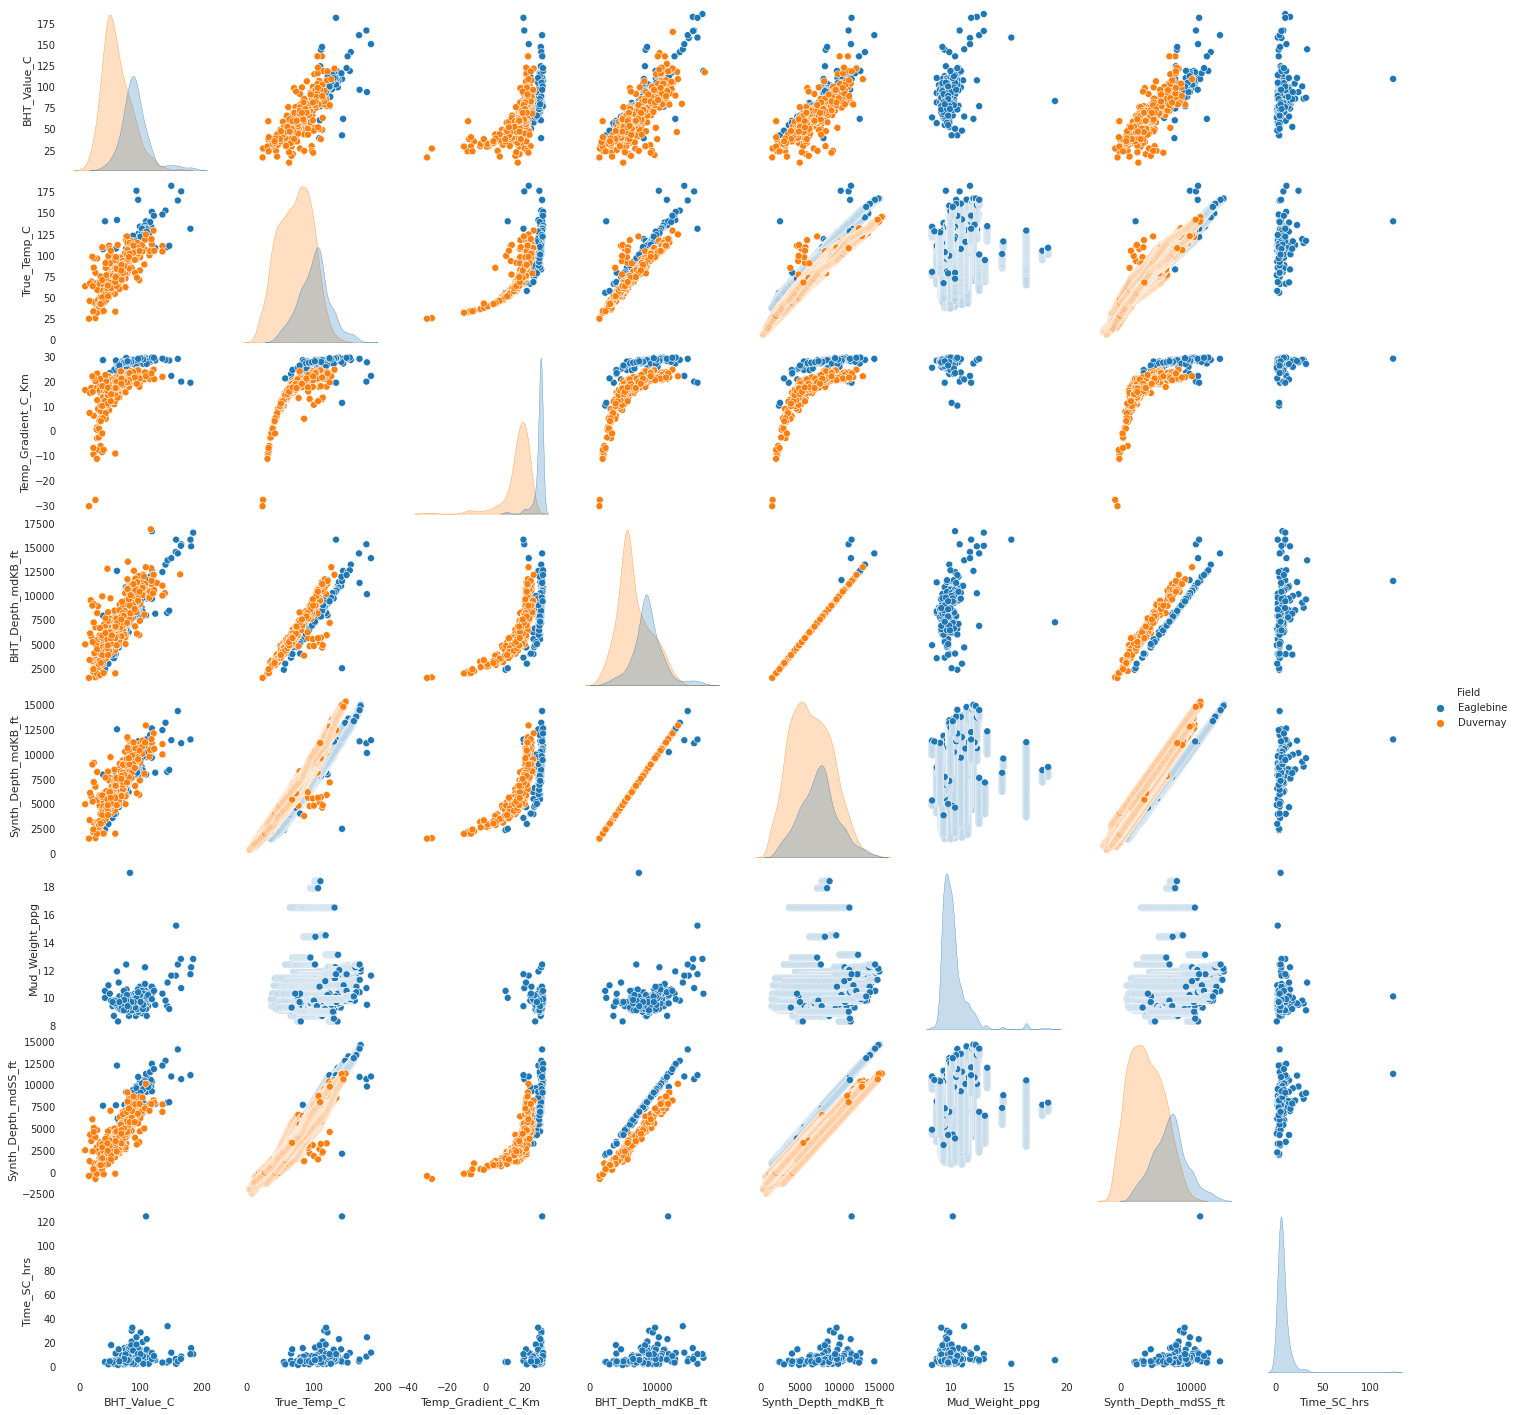

In [47]:
ax = sns.pairplot(Selected_for_pair, hue='Field')

##4.3 Take a Closer Look

Both the "True Temperature" and the BHT are strongly correlated to Depth.

The True formation Temperature tends to be higher than the BHT recorded. BHT value is affected by heat loss during drilling mud circulation.

Positive trend of Temperature and Depth is observed in both basins, Eaglebine and Duvernay.

Text(0.5, 1.0, 'Eaglebine')

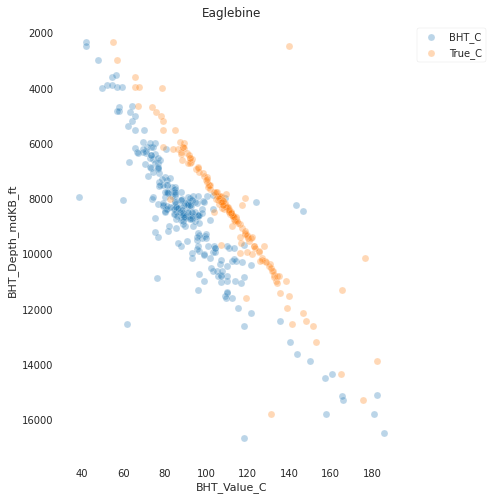

In [62]:
basin='Eaglebine'

fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features.loc[GTX_features['Field']==basin], x="BHT_Value_C", y="BHT_Depth_mdKB_ft", ax=ax, alpha=0.3)
sns.scatterplot(data=GTX_features.loc[GTX_features['Field']==basin], x="True_Temp_C", y="BHT_Depth_mdKB_ft", ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(['BHT_C', 'True_C'], bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title(basin, size=12)

Text(0.5, 1.0, 'Duvernay')

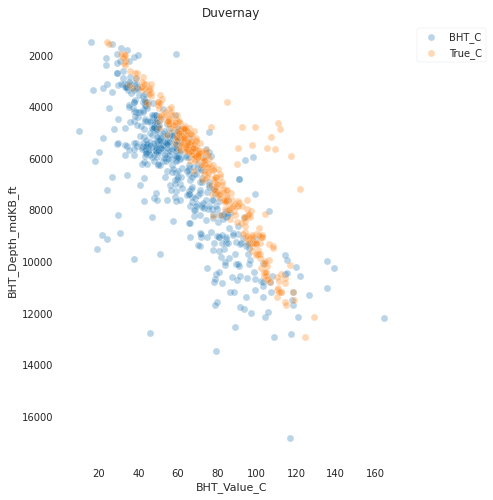

In [63]:
basin='Duvernay'

fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features.loc[GTX_features['Field']==basin], x="BHT_Value_C", y="BHT_Depth_mdKB_ft", ax=ax, alpha=0.3)
sns.scatterplot(data=GTX_features.loc[GTX_features['Field']==basin], x="True_Temp_C", y="BHT_Depth_mdKB_ft", ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(['BHT_C', 'True_C'], bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title(basin, size=12)

BHTs and True Temperatures tend to be higher in Eaglebine than in Duvernay. A clear shift is observed.

Could this be linked to higher yearly average surface temperature in Eaglebine (Texas) vs Duvernay (Alberta, Canada)? The basin location appears to be a strong indicator of a shift in temperature.

Text(0.5, 1.0, 'True Temperature vs Depth (Eaglebine and Duvernay)')

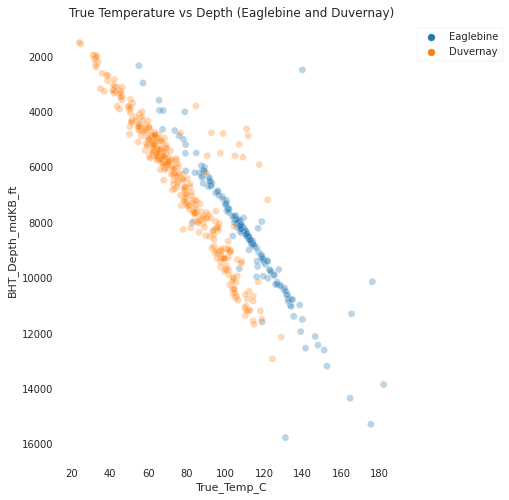

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features, x="True_Temp_C", y="BHT_Depth_mdKB_ft", hue='Field', ax=ax, alpha=0.3)
# sns.regplot(x="BHT_Value_C", y="BHT_Depth_mdKB_ft", 
#                     data=GTX_features,
#                     scatter_kws={'alpha':0.15},
#                     fit_reg=False)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title('True Temperature vs Depth (Eaglebine and Duvernay)', size=12)

Text(0.5, 1.0, 'BHT vs Depth (Eaglebine and Duvernay)')

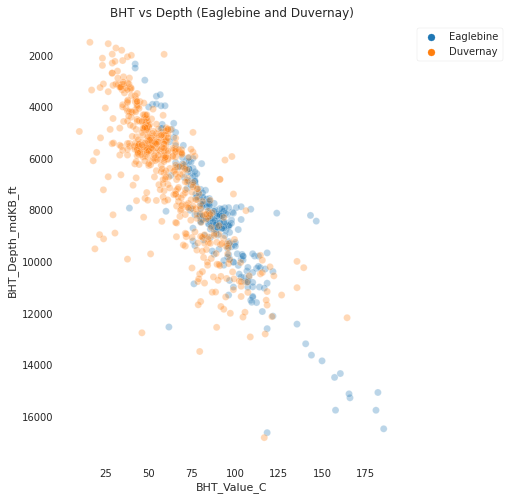

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features, x="BHT_Value_C", y="BHT_Depth_mdKB_ft", hue='Field', ax=ax, alpha=0.3)
# sns.regplot(x="BHT_Value_C", y="BHT_Depth_mdKB_ft", 
#                     data=GTX_features,
#                     scatter_kws={'alpha':0.15},
#                     fit_reg=False)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title('BHT vs Depth (Eaglebine and Duvernay)', size=12)

Text(0.5, 1.0, 'BHT vs True Temperature (Eaglebine and Duvernay)')

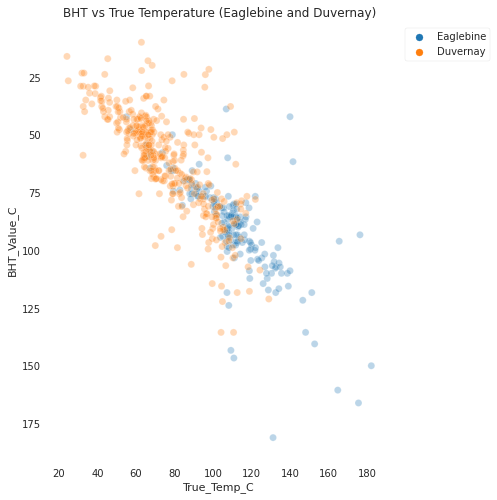

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features, x="True_Temp_C", y="BHT_Value_C", hue='Field', ax=ax, alpha=0.3)
# sns.regplot(x="BHT_Value_C", y="BHT_Depth_mdKB_ft", 
#                     data=GTX_features,
#                     scatter_kws={'alpha':0.15},
#                     fit_reg=False)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title('BHT vs True Temperature (Eaglebine and Duvernay)', size=12)

Text(0.5, 1.0, 'BHT vs Time SC (Eaglebine and Duvernay)')

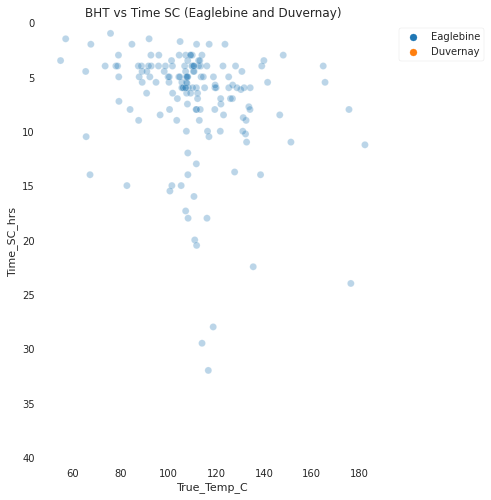

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features, x="True_Temp_C", y="Time_SC_hrs", hue='Field', ax=ax, alpha=0.3)
# sns.regplot(x="BHT_Value_C", y="BHT_Depth_mdKB_ft", 
#                     data=GTX_features,
#                     scatter_kws={'alpha':0.15},
#                     fit_reg=False)

# ax.set_xlim([30, 220])
ax.set_ylim([0, 40])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title('BHT vs Time SC (Eaglebine and Duvernay)', size=12)

Text(0.5, 1.0, 'BHT vs Mud Weight (Eaglebine and Duvernay)')

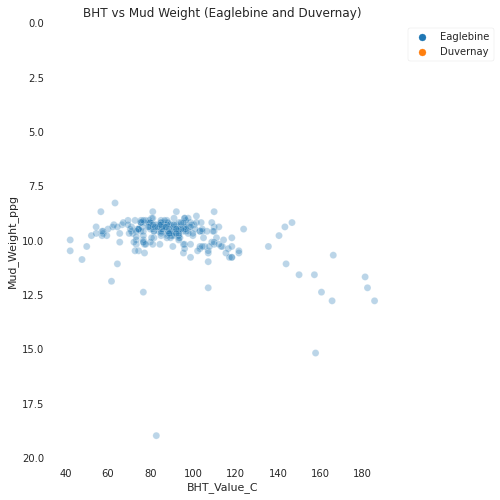

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6,8))

sns.scatterplot(data=GTX_features, x="BHT_Value_C", y="Mud_Weight_ppg", hue='Field', ax=ax, alpha=0.3)
# sns.regplot(x="BHT_Value_C", y="BHT_Depth_mdKB_ft", 
#                     data=GTX_features,
#                     scatter_kws={'alpha':0.15},
#                     fit_reg=False)

# ax.set_xlim([30, 220])
ax.set_ylim([0, 20])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().invert_yaxis()
plt.title('BHT vs Mud Weight (Eaglebine and Duvernay)', size=12)

The "BHT correction" is the difference between the True Formation temperature and the BHT.

The average absolute correction (in degrees C) tends to be higher in Eaglebine than in Duvernay.

However, the average BHT correction in percent terms (relative change) is actually very similar in both basins. Duvernay shows more variability in the correction factors.

Text(0.5, 1.0, 'BHT Correction Distribution')

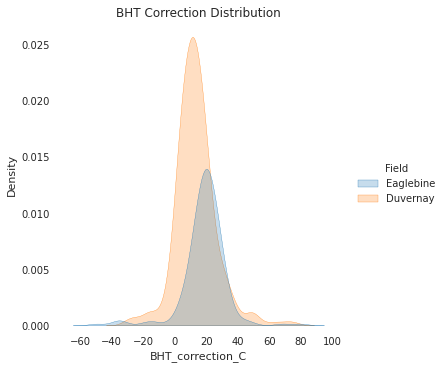

In [69]:
sns.displot(GTX_features, x="BHT_correction_C", hue="Field", kind="kde", fill=True)
plt.title('BHT Correction Distribution', size=12)

Text(0.5, 1.0, 'BHT Correction % Distribution')

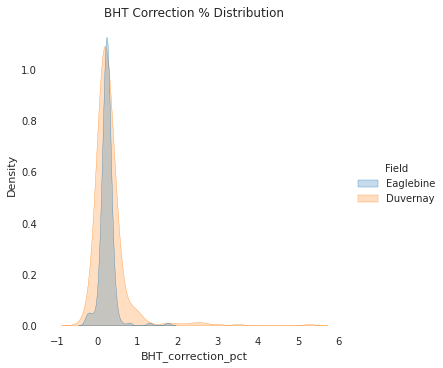

In [70]:
sns.displot(GTX_features, x="BHT_correction_pct", hue="Field", kind="kde", fill=True)
plt.title('BHT Correction % Distribution', size=12)

Text(0.5, 1.0, 'BHT Correction vs Depth')

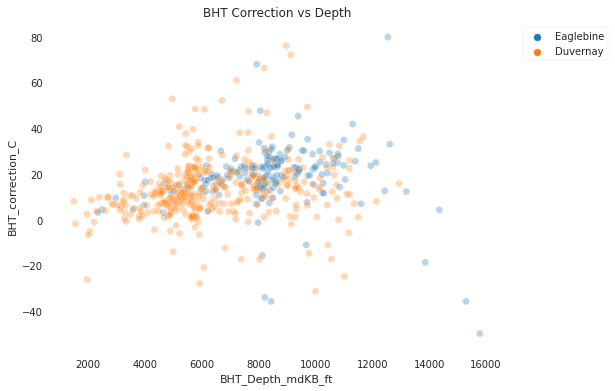

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="BHT_Depth_mdKB_ft", y="BHT_correction_C", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction vs Depth', size=12)

Text(0.5, 1.0, 'BHT Correction vs TSC')

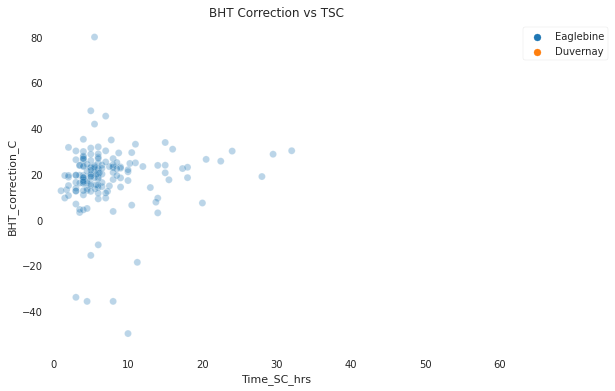

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="Time_SC_hrs", y="BHT_correction_C", hue='Field', ax=ax, alpha=0.3)

ax.set_xlim([0, 60])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction vs TSC', size=12)

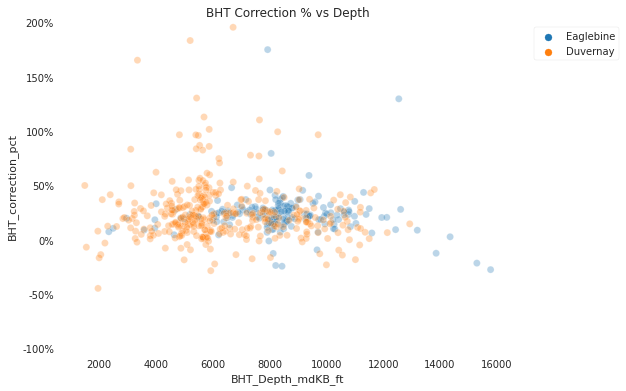

In [73]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="BHT_Depth_mdKB_ft", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs Depth', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

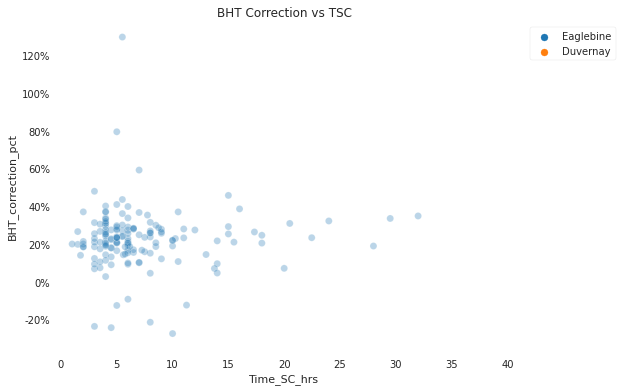

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="Time_SC_hrs", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

ax.set_xlim([0, 40])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction vs TSC', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

The BHT correction percent, shows some interaction with Depth. At higher Depths, the BHT correction factor tends to be lower.

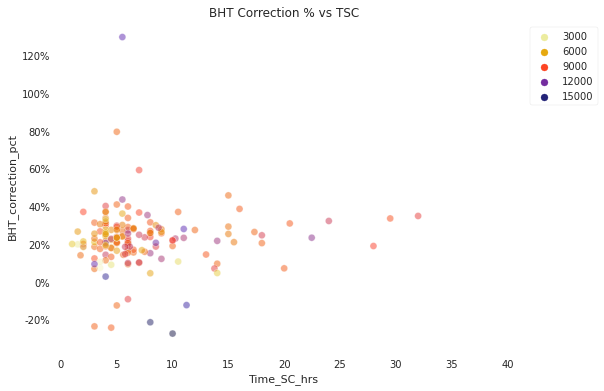

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="Time_SC_hrs", y="BHT_correction_pct", hue='BHT_Depth_mdKB_ft', ax=ax, palette='CMRmap_r', alpha=0.5)

ax.set_xlim([0, 40])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs TSC', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

Text(0.5, 1.0, 'BHT Correction vs TSC')

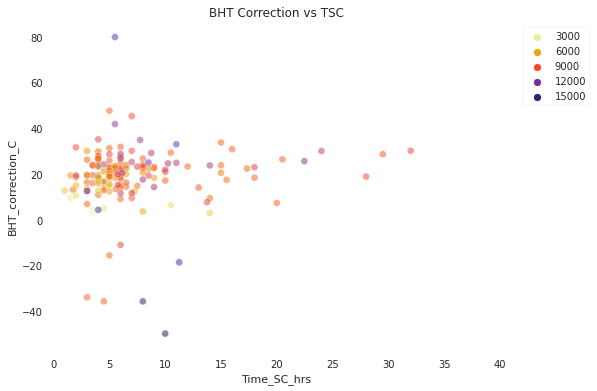

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="Time_SC_hrs", y="BHT_correction_C", hue='BHT_Depth_mdKB_ft', ax=ax, palette='CMRmap_r', alpha=0.5)

ax.set_xlim([0, 40])
# ax.set_ylim([30, 220])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction vs TSC', size=12)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

Some potential trend of BHT correction with Mud Weight? Apparently higher mud weights imply lower correction factors.

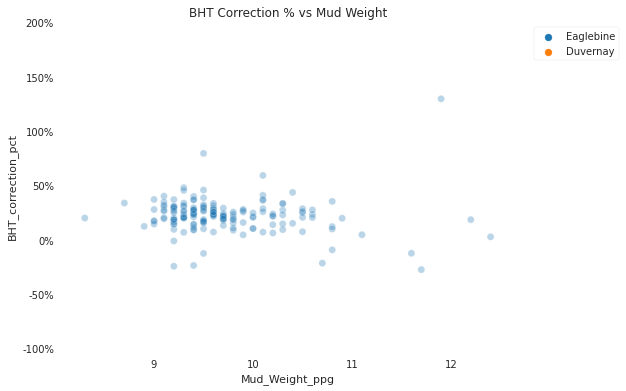

In [77]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="Mud_Weight_ppg", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs Mud Weight', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

The top 5 most popular logs were averaged over the Formation where the BHT was taken.

Hypothesis was that lithology might have an effect on the thermal conductivity of the rock, and might impact BHT warm-back and BHT correction.

The charts below show no correlation of the petrophysical summaries with the BHT corrections. Maybe some weak negative trend with DRESWS (deep resistivity).

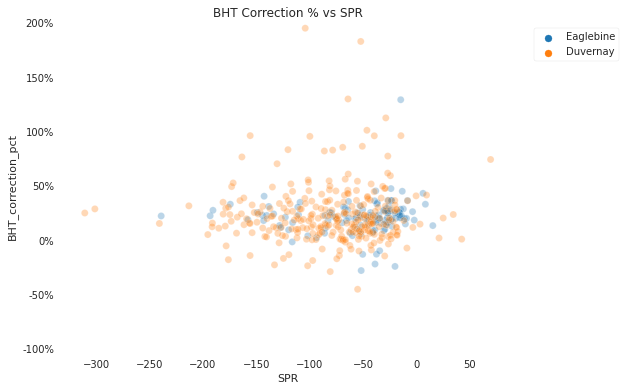

In [78]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="SPR", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs SPR', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

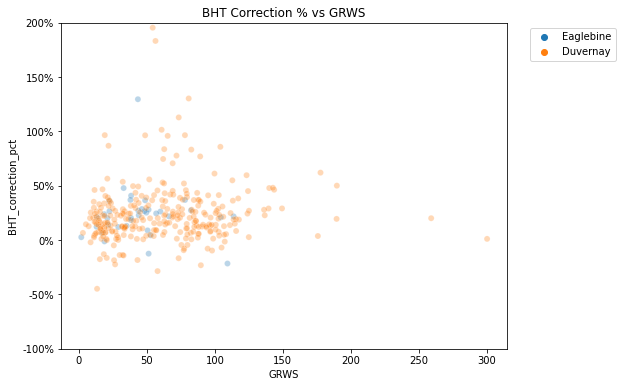

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="GRWS", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([30, 220])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs GRWS', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

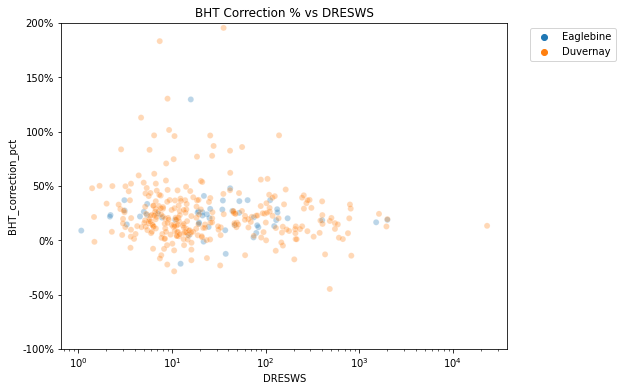

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="DRESWS", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([0, 2000])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs DRESWS', size=12)
ax.set(xscale="log")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

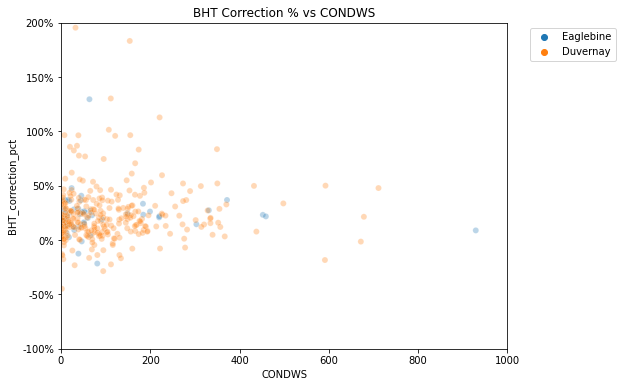

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="CONDWS", y="BHT_correction_pct", hue='Field', ax=ax,  alpha=0.3)

ax.set_xlim([0, 1000])
ax.set_ylim([-1, 2])
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs CONDWS', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

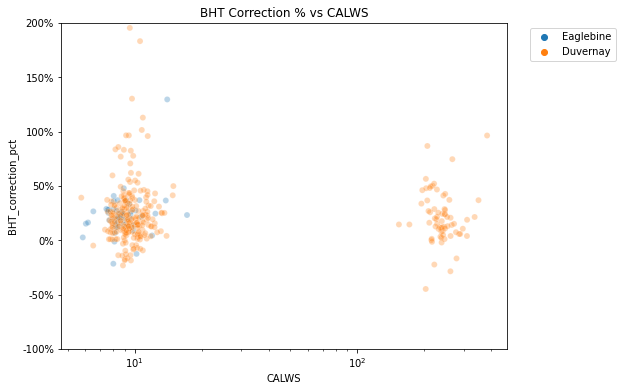

In [ ]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8,6))

sns.scatterplot(data=GTX_features, x="CALWS", y="BHT_correction_pct", hue='Field', ax=ax, alpha=0.3)

# ax.set_xlim([0, 10])
ax.set_ylim([-1, 2])
ax.set(xscale="log")
# ax.plot([0, 220], [0, 220], label='1-1', c='k') # 1:1 line

# ax.plot(x, y_hat, label='linear pred', c='r')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.gca().invert_yaxis()
plt.title('BHT Correction % vs CALWS', size=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

##4.4 Select Features

From EDA above formation temperature is clearly strongly correlated with depth. Also Eaglebine generally has hotter BHT than Duvernay. Formation is also selected as feature for model training accodring to some literature. Coordinates of the well are added to find "hot spot" in each field.

# 5.0 Random Forest Regression Modeling

## 5.1 Create base RF model

In [79]:
from sklearn.model_selection import train_test_split

# list of features included in regression model
sel_features = ['Depth_mdGL_ft', 'Field_enc', 'Formation_enc', 'Lat', 'Long']

# # remove rows with incomplete features if any
# GTX_features_notna = train.dropna(subset=sel_features, how='any')

X = train[sel_features]
y = train.Synth_Value_C

# # scale features NOT NEEDED FOR RANDOM FOREST
# X_norm = X.copy(deep=True)
# X_norm[['BHT_Depth_mdKB_ft','BHT_Value_C']] = scale(X[['Depth_mdGL_ft','Lat', 'Long']])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


In [80]:
# Create Base model with default RF regressor parameters
# it's a thousand trees, be patient

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

base_rf_model = RandomForestRegressor(
    n_estimators = 1000, 
    random_state = 42,
    max_depth= 100,
    max_features='auto',
    min_samples_leaf= 1,
    min_samples_split= 2,
    verbose=0
)
base_rf_model.fit(X_train, y_train)

# train score
print('Train R2, MAE, RMSE:')
y_train_pred = base_rf_model.predict(X_train)
print(base_rf_model.score(X_train, y_train))
print(mean_absolute_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

# test score
print('Test R2, MAE, RMSE:')
y_test_pred = base_rf_model.predict(X_test)
print(base_rf_model.score(X_test, y_test)) #default regression loss function is R2
print(mean_absolute_error(y_test, y_test_pred))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))


Train R2, MAE, RMSE:
0.9998934094880031
0.20828067434730982
0.28224447333626884
Test R2, MAE, RMSE:
0.9992553749174076
0.5569545128876369
0.7485996245792718


## 5.2 Visualize Results

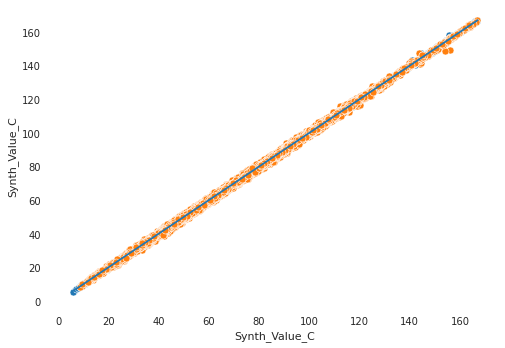

In [81]:
# residual plot, includes full synthetic data points for every well, slow
fig, ax = plt.subplots()
sns.scatterplot(y_train_pred, y_train, ax=ax)
sns.scatterplot(y_test_pred, y_test, ax=ax)
sns.lineplot(y_train, y_train, ax=ax)
plt.show()

In [82]:
base_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

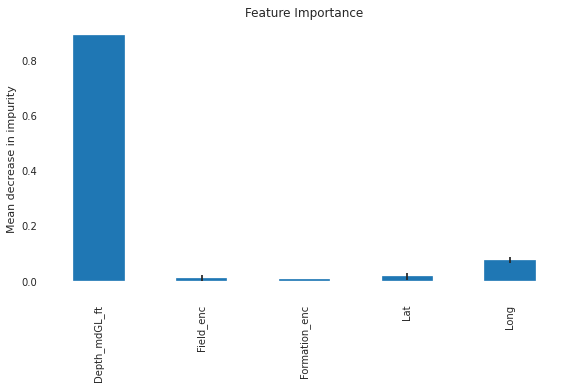

In [83]:
# Feature importance
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

feat_names = X.columns.values
importances = base_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feat_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# 6.0 Submit Prediction

## 6.1 Use the regression model to predict on the validation set

In [99]:
validation_data = pd.read_csv(dir_notebook+'GTX_dataset_validation.csv')
validation_data.head()

UWI      GL_ft  ...  Field_enc                 Set
0    42493322270000   487.4000  ...        1.0  Validation_Testing
1    42507312420000   660.7000  ...        1.0  Validation_Testing
2  100012404516W502  4206.2420  ...        0.0  Validation_Testing
3  100012805703W500  2309.1678  ...        0.0  Validation_Testing
4  100020206419W500  2474.2021  ...        0.0  Validation_Testing

[5 rows x 35 columns]

In [100]:
# do prediction on validation set
prediction = base_rf_model.predict(validation_data[sel_features])

In [101]:
# Impute missing True Temperatures in validation set using our new predictions
validation_data['TrueTemp']=prediction

## 6.2 Export predictions into zip file for Codalab competition

In [102]:
# export columns with UWI and true temperature to csv file
validation_data[['UWI','TrueTemp']].to_csv('predictions.csv')

In [103]:
# Codalab requires submission to be in a compressed zip file
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

## **THE END**